In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from sklearn.svm import SVC,LinearSVC
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import seaborn as sns


from plots import plot_scatter,focus_map,classification_map
from plots import plot_training_metric,plot_analysis
from mosaic_from_boundary import boundary_mosaic_points
from Mosaic import MosaicDataset
from Models import Focus_deep,Classification_deep
from train_model import train
#torch.manual_seed(125)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu
cpu


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Generate dataset

In [2]:
# y = np.random.randint(0,3,150)
# idx= []
# for i in range(3):
#     print(i,sum(y==i))
#     idx.append(y==i)

In [3]:
# x = np.zeros((150,2))

In [4]:
# x[idx[0]] = np.random.uniform(low =[-5,0],high =[50,50],size= (sum(idx[0]),2))
# x[idx[1]] = np.random.uniform(low =[-5,100],high =[50,150],size= (sum(idx[1]),2))
# x[idx[2]] = np.random.uniform(low =[90,0],high =[150,120],size= (sum(idx[2]),2))


In [5]:
boundary_points =  np.array([[-5,0],[50,50],[50,0],[-5,50],[-5,100],[-5,150],[50,100],[50,150],[90,0],[150,120],[90,120],[150,0]])
y_boundary_pts = np.array([0,0,0,0,1,1,1,1,2,2,2,2])


# Visualise Data Distribution

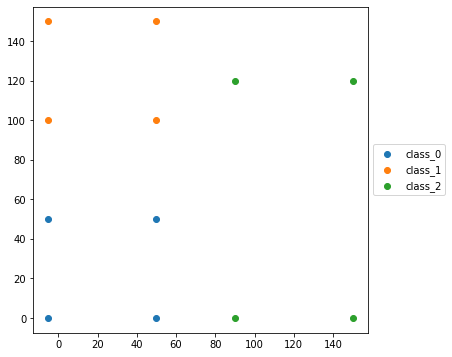

In [6]:
#plot_scatter(x,y,"distribution")
plot_scatter(boundary_points,y_boundary_pts,"distribution")

In [7]:
# foreground_classes = {'class_0','class_1'}

# background_classes = {'class_2'}

In [8]:
# desired_num = 1000
# mosaic_list =[]
# mosaic_label = []
# fore_idx=[]
# for j in range(desired_num):
#     fg_class  = np.random.randint(0,2)
#     fg_idx = np.random.randint(0,3)
#     bg_class = 2
#     a = []
#     for i in range(3):
#         if i == fg_idx:
#             b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
#             a.append(x[b])
#         else:
#             b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
#             a.append(x[b])
#     a = np.concatenate(a,axis=0)
#     mosaic_list.append(np.reshape(a,(6,1)))
#     mosaic_label.append(fg_class)
#     fore_idx.append(fg_idx)

In [9]:
# mosaic_list = np.concatenate(mosaic_list,axis=1).T
# print(mosaic_list)

In [10]:
# print(np.shape(mosaic_label))
# print(np.shape(fore_idx))

In [11]:
x_b,y_b,f_index = boundary_mosaic_points(boundary_points,y_boundary_pts)

In [12]:
# mosaic_list = np.concatenate((mosaic_list,x_b),axis=0)
# mosaic_label = np.concatenate((mosaic_label,y_b),axis=0)
# fore_idx = np.concatenate((fore_idx,f_index),axis=0)

In [13]:
#print(mosaic_list.shape,mosaic_label.shape,fore_idx.shape)
print(x_b.shape,y_b.shape,len(f_index))

(384, 6) (384,) 384


In [14]:
#batch = 250  # use batch 50 for only boundary points
batch = 50
#msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
msd = MosaicDataset(x_b, y_b , np.array(f_index))
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [15]:
net  = Classification_deep(6,2).double()
net  = net.to(device)


In [16]:
criter = nn.CrossEntropyLoss()
optimizr = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
for i in range(50):
  net.train()
  train_loss1 = 0
  correct1 = 0
  total1 = 0
  for batch_idx, (inputs1, targets1,_) in enumerate(train_loader):
    inputs1 =inputs1.double()
    inputs1, targets1 = inputs1.to(device), targets1.to(device)
    optimizr.zero_grad()
    outputs1 = net(inputs1)
    loss1 = criter(outputs1, targets1)
    loss1.backward()
    optimizr.step()
    train_loss1 += loss1.item()
    _, predicted1 = outputs1.max(1)
    total1 += targets1.size(0)
    correct1 += predicted1.eq(targets1).sum().item()
  print("epoch, train accuracy, loss ",i,correct1/total1 ,train_loss1/(batch_idx+1))

epoch, train accuracy, loss  0 0.4895833333333333 11.061781934914269
epoch, train accuracy, loss  1 0.5963541666666666 4.953617875538959
epoch, train accuracy, loss  2 0.640625 2.8901682702310842
epoch, train accuracy, loss  3 0.6380208333333334 1.7043119673515938
epoch, train accuracy, loss  4 0.6770833333333334 0.8617607878871533
epoch, train accuracy, loss  5 0.6692708333333334 0.7707474093160375
epoch, train accuracy, loss  6 0.6796875 0.6472109331888818
epoch, train accuracy, loss  7 0.6744791666666666 0.6437052837160143
epoch, train accuracy, loss  8 0.6692708333333334 0.6264959259554601
epoch, train accuracy, loss  9 0.6692708333333334 0.6092180794709535
epoch, train accuracy, loss  10 0.6432291666666666 0.6128636043672768
epoch, train accuracy, loss  11 0.6744791666666666 0.5845519193773273
epoch, train accuracy, loss  12 0.6875 0.5825851015120217
epoch, train accuracy, loss  13 0.6744791666666666 0.5867760709309646
epoch, train accuracy, loss  14 0.6770833333333334 0.583713869

In [17]:
X = []
Y = []
for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
        
    X.append(inputs.numpy())
    Y.append(labels.numpy())
X = np.concatenate(X,axis=0)
Y  = np.concatenate(Y,axis=0)

In [18]:
clf = LinearSVC(C= 1000000,random_state = 1)

In [19]:
clf.fit(X,Y)
print(clf.score(X,Y))

0.6640625


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [20]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(2,1)
    def forward(self,z):
        batch = z.shape[0]
        x = torch.zeros([batch,3],dtype=torch.float64)
        y = torch.zeros([batch,2], dtype=torch.float64)
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(3):
            x[:,i] = self.helper(z[:,2*i:2*i+2])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        #print(x.shape)
        x1 = x[:,0]
        for i in range(3):
            x1 = x[:,i]          
            y = y+torch.mul(x1[:,None],z[:,2*i:2*i+2])
        return y , x 

    
    def helper(self,x):
        x = self.linear1(x)
        #x = F.relu(self.linear2(x))
        #x = self.linear3(x)
        
        return x

    

In [21]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,2)
#         self.linear2 = nn.Linear(8,16)
#         self.linear3 = nn.Linear(16,3)
    def forward(self,x):
        x = self.linear1(x)
#         x = F.relu(self.linear2(x))
#         x = self.linear3(x)
        return x

In [22]:
#where = Wherenet().double()
where = Focus_deep(2,1).double()
#focus_map(where)

In [23]:
#what =Whatnet().double()
what = Classification_deep(2,2).double()

[1,     7] loss: 6.088
[1,    7] accuracy: 0.526
[2,     7] loss: 0.876
[2,    7] accuracy: 0.637
[3,     7] loss: 0.602
[3,    7] accuracy: 0.720
[4,     7] loss: 0.497
[4,    7] accuracy: 0.726
[5,     7] loss: 0.420
[5,    7] accuracy: 0.874
[6,     7] loss: 0.411
[6,    7] accuracy: 0.834
[7,     7] loss: 0.406
[7,    7] accuracy: 0.797
[8,     7] loss: 0.390
[8,    7] accuracy: 0.880
[9,     7] loss: 0.402
[9,    7] accuracy: 0.871
[10,     7] loss: 0.390
[10,    7] accuracy: 0.877


/content/plots.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(6,6))
/content/plots.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(6,6))


[11,     7] loss: 0.390
[11,    7] accuracy: 0.880
[12,     7] loss: 0.384
[12,    7] accuracy: 0.877
[13,     7] loss: 0.394
[13,    7] accuracy: 0.871
[14,     7] loss: 0.381
[14,    7] accuracy: 0.874
[15,     7] loss: 0.379
[15,    7] accuracy: 0.874
[16,     7] loss: 0.389
[16,    7] accuracy: 0.866
[17,     7] loss: 0.375
[17,    7] accuracy: 0.877
[18,     7] loss: 0.378
[18,    7] accuracy: 0.871
[19,     7] loss: 0.371
[19,    7] accuracy: 0.874
[20,     7] loss: 0.366
[20,    7] accuracy: 0.883
[21,     7] loss: 0.363
[21,    7] accuracy: 0.817
[22,     7] loss: 0.351
[22,    7] accuracy: 0.889
[23,     7] loss: 0.363
[23,    7] accuracy: 0.809
[24,     7] loss: 0.356
[24,    7] accuracy: 0.814
[25,     7] loss: 0.363
[25,    7] accuracy: 0.866
[26,     7] loss: 0.352
[26,    7] accuracy: 0.871
[27,     7] loss: 0.352
[27,    7] accuracy: 0.794
[28,     7] loss: 0.343
[28,    7] accuracy: 0.883
[29,     7] loss: 0.349
[29,    7] accuracy: 0.769
[30,     7] loss: 0.338
[30,   

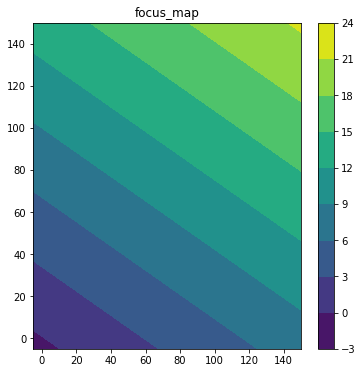

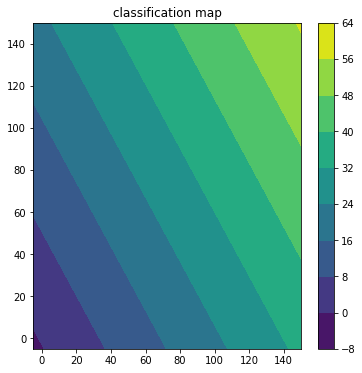

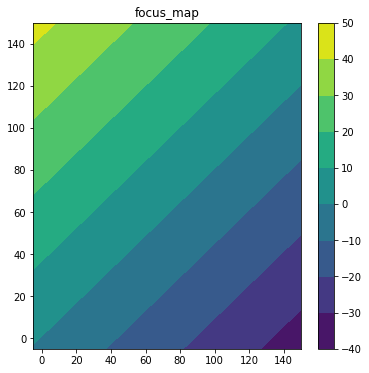

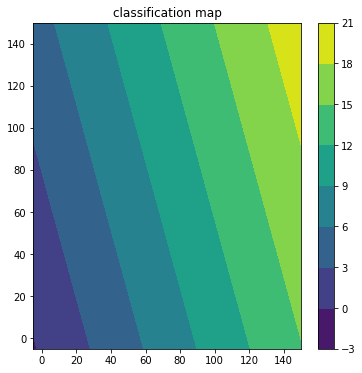

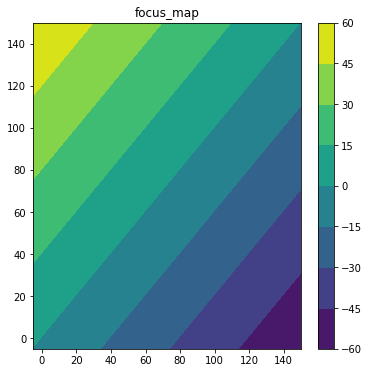

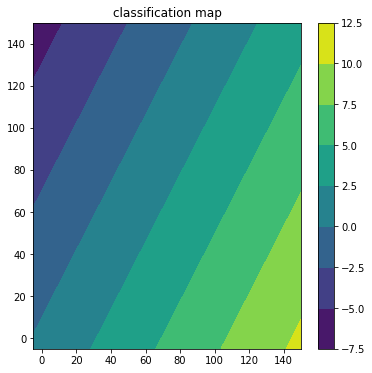

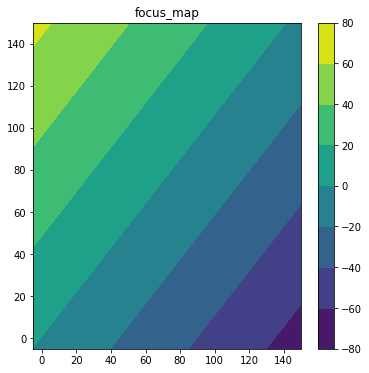

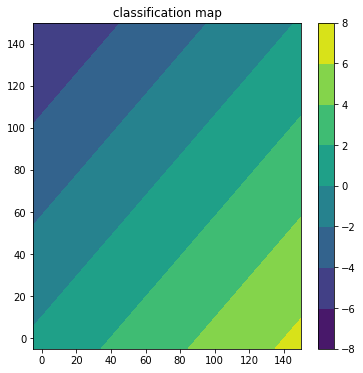

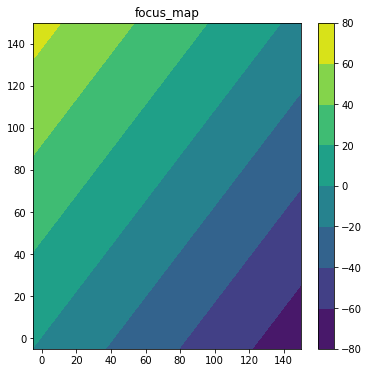

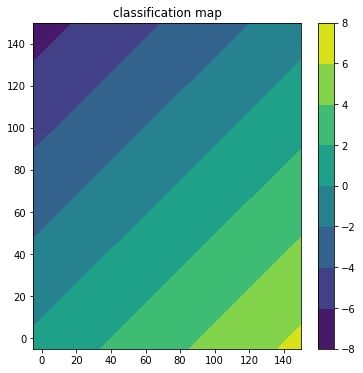

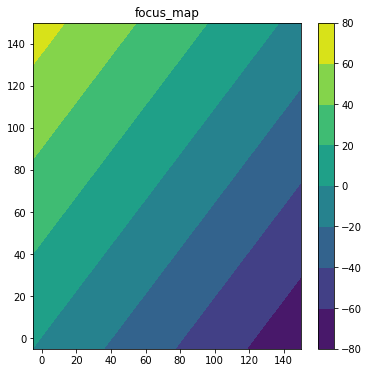

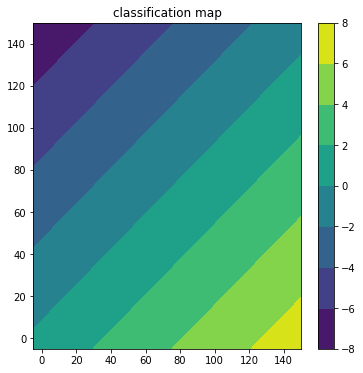

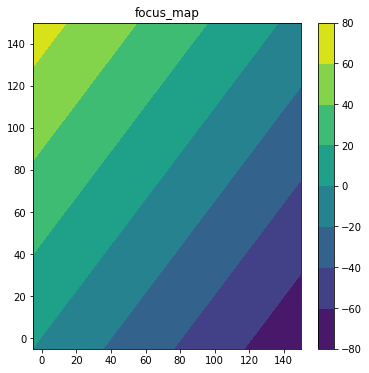

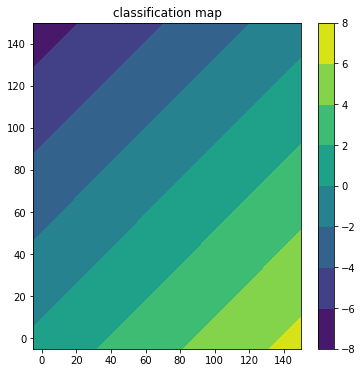

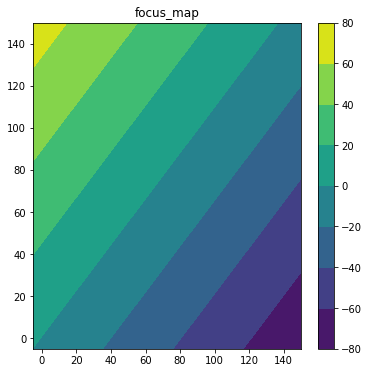

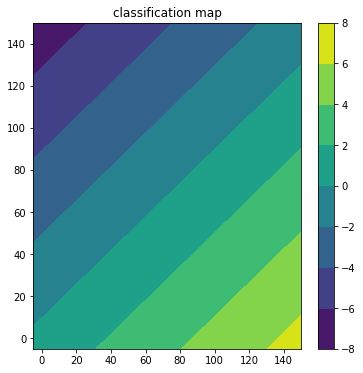

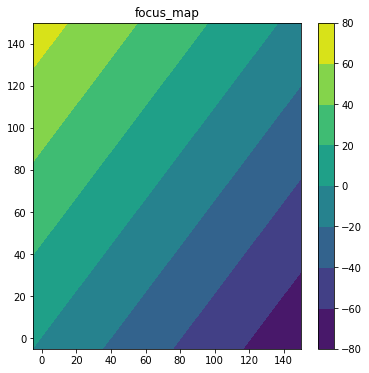

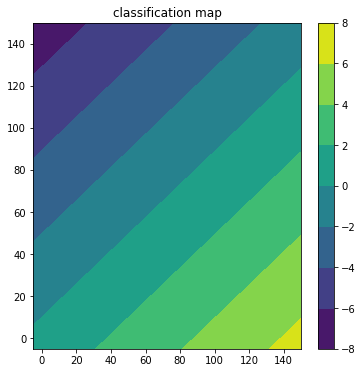

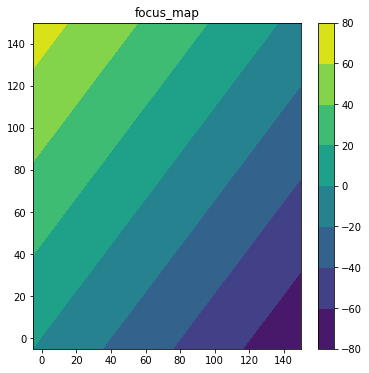

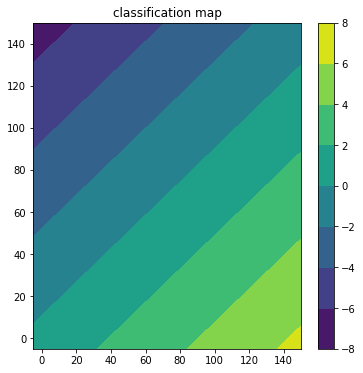

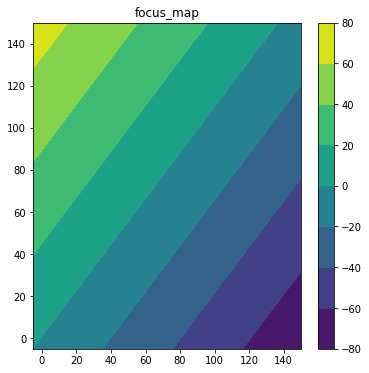

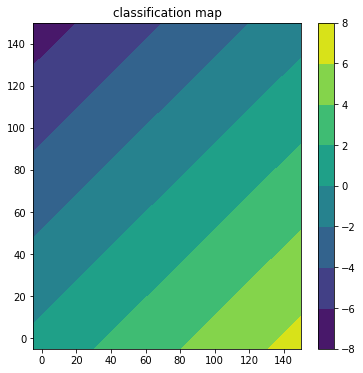

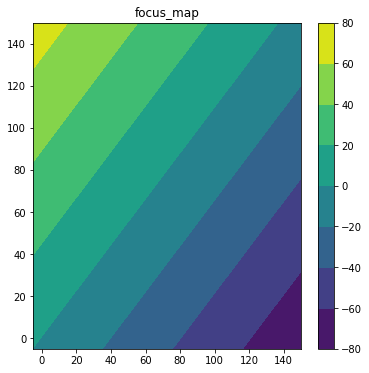

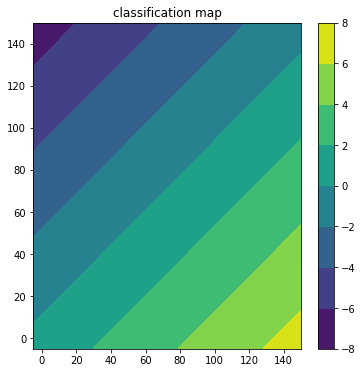

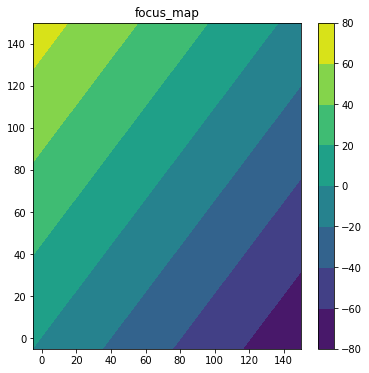

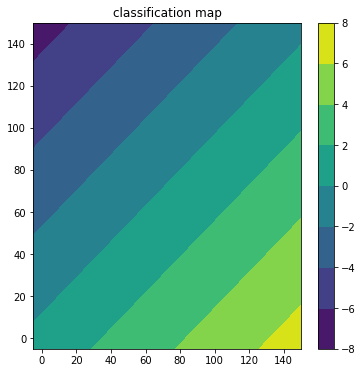

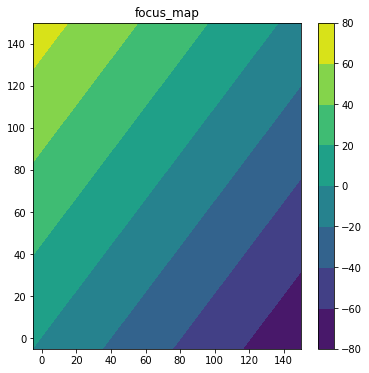

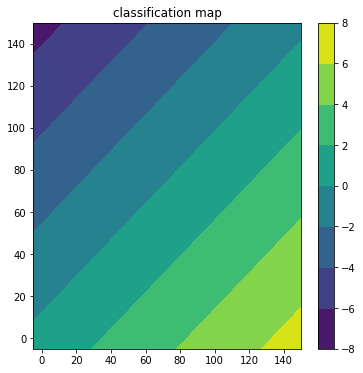

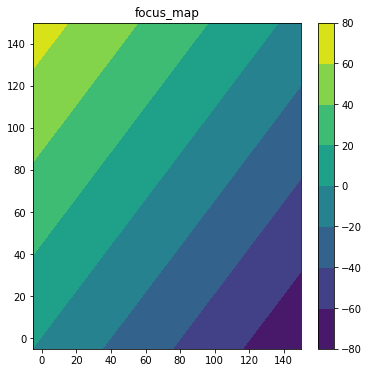

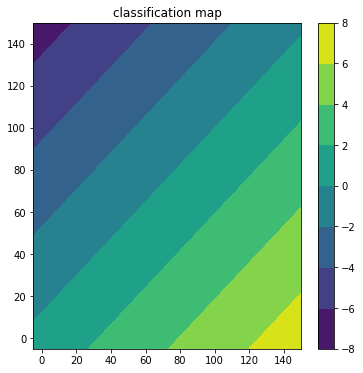

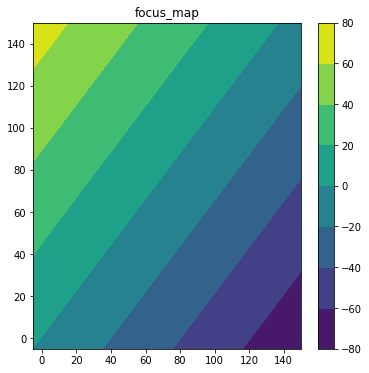

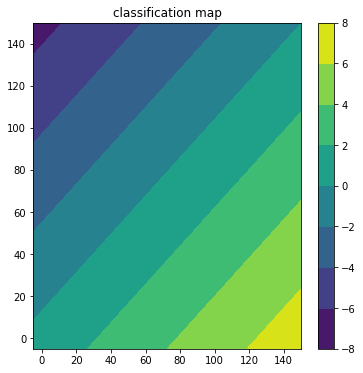

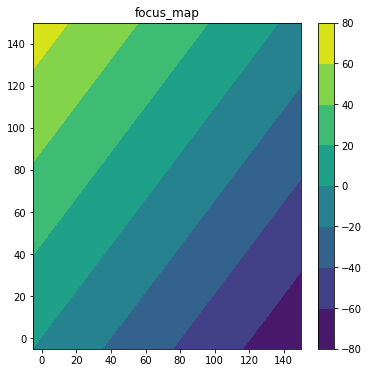

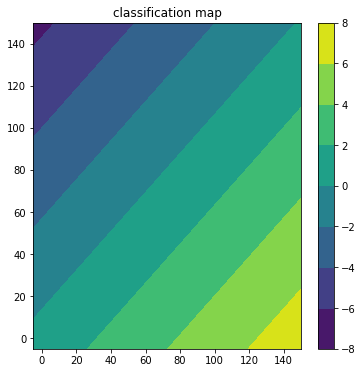

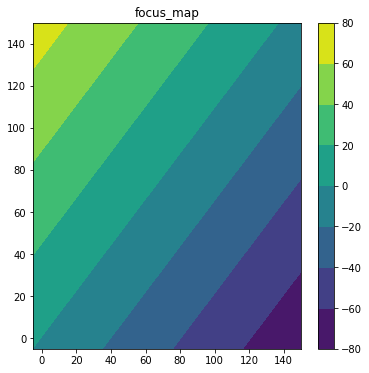

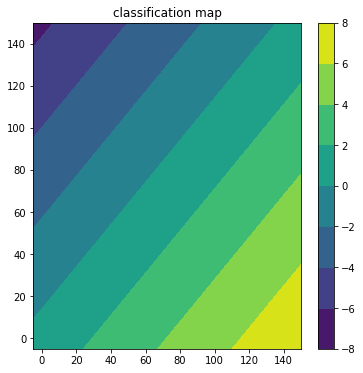

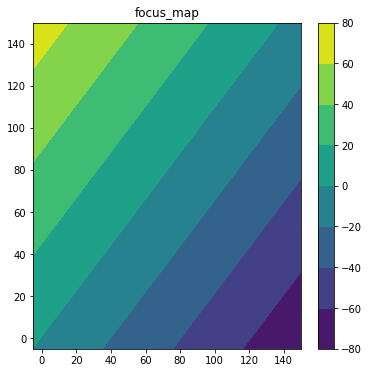

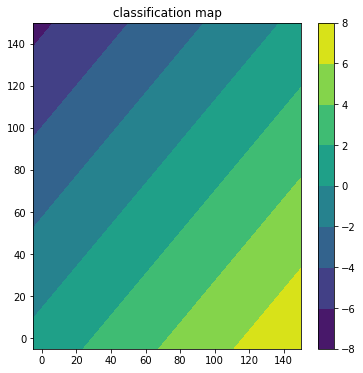

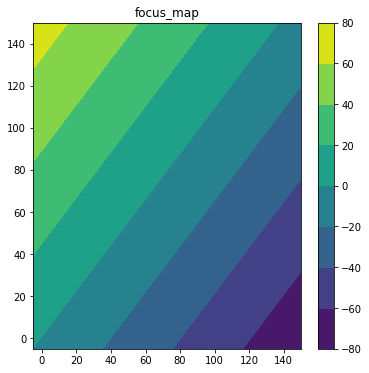

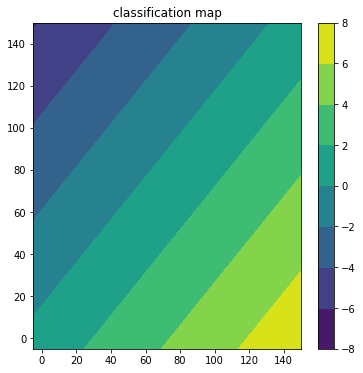

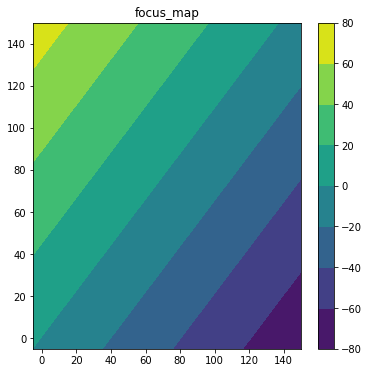

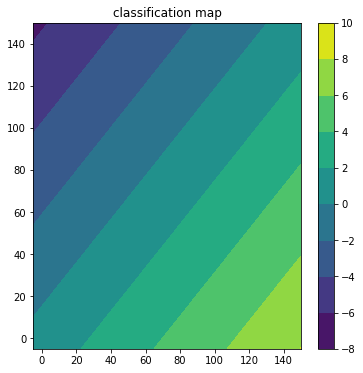

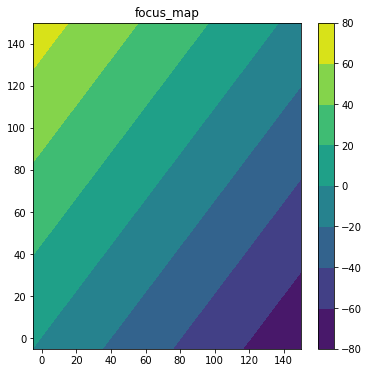

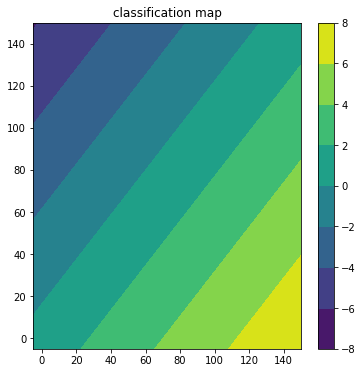

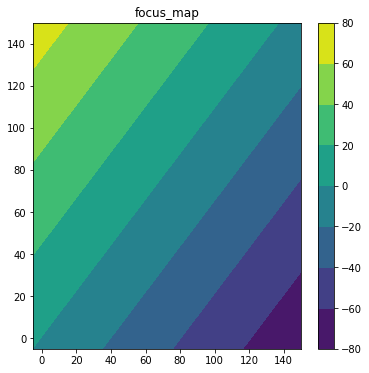

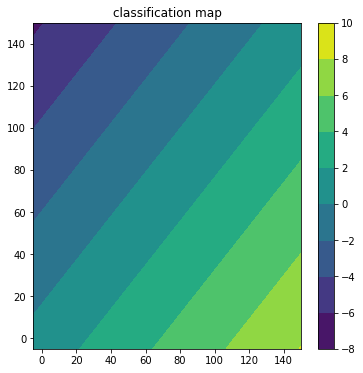

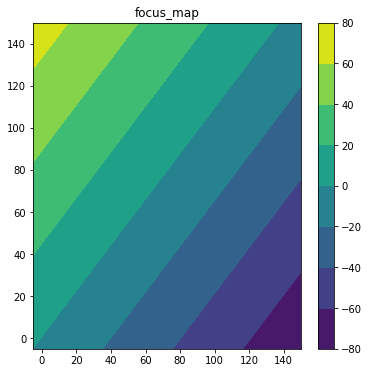

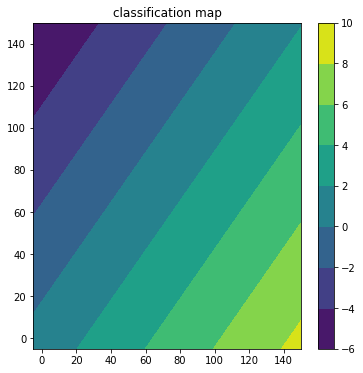

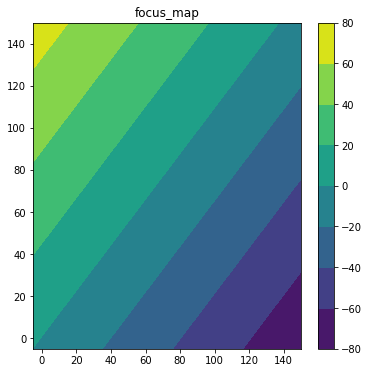

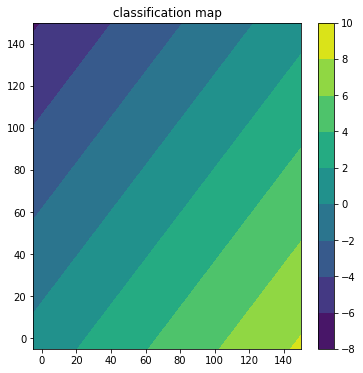

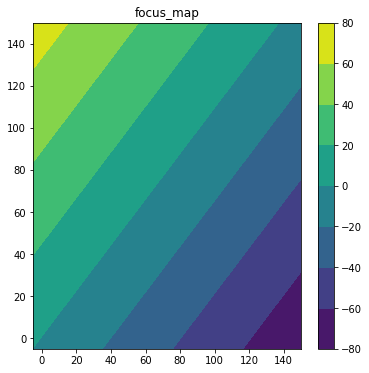

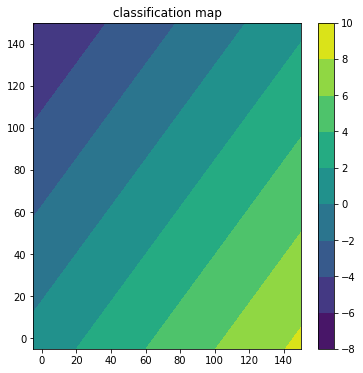

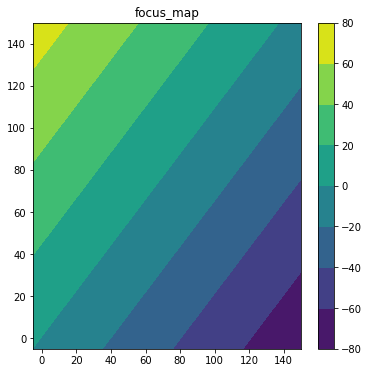

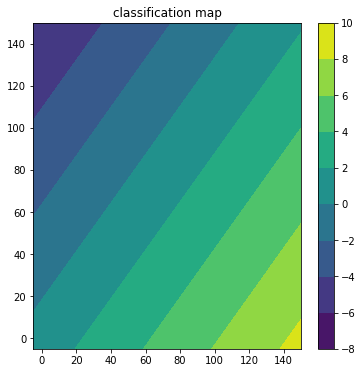

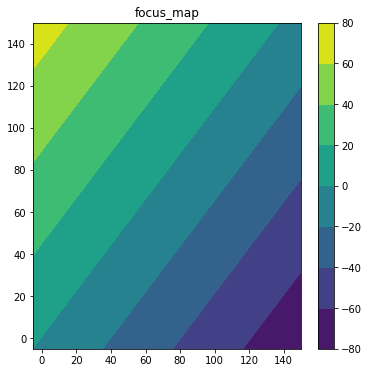

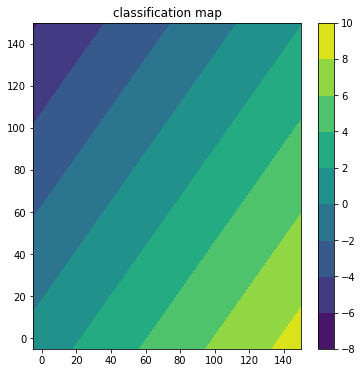

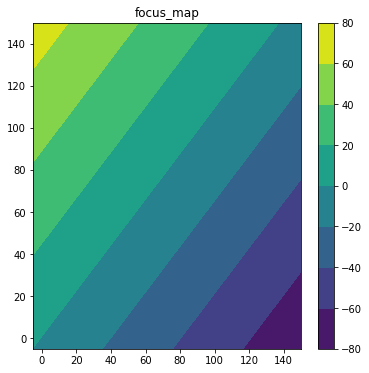

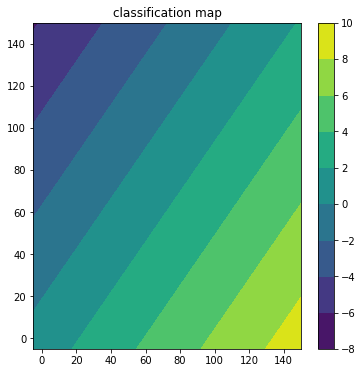

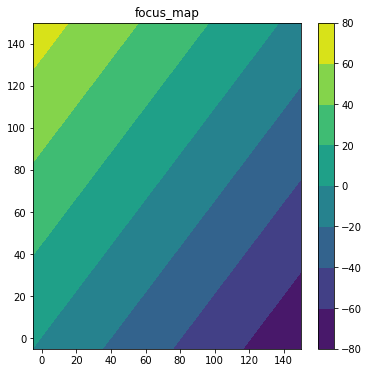

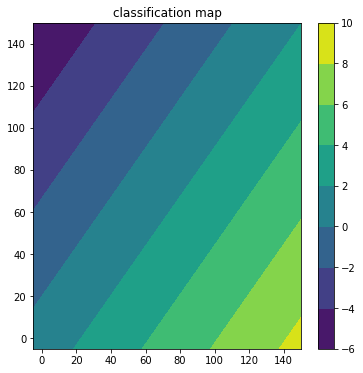

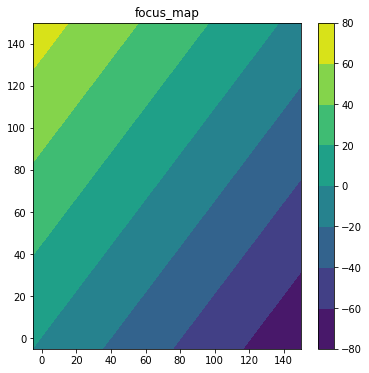

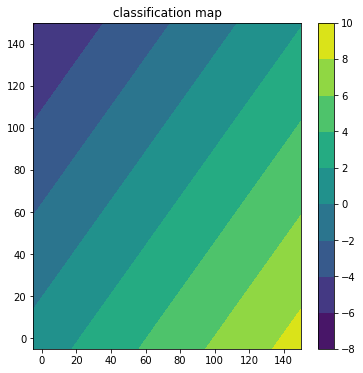

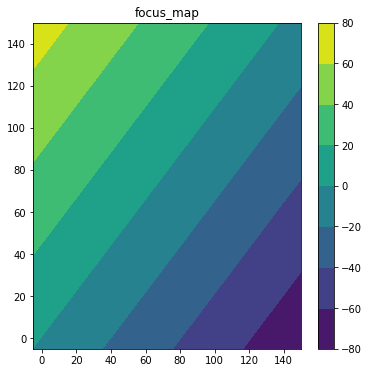

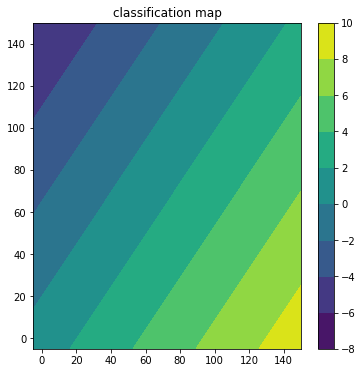

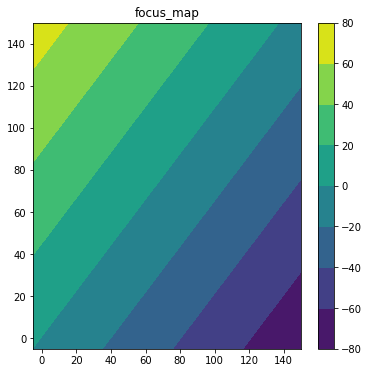

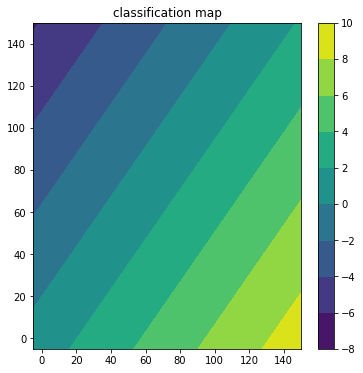

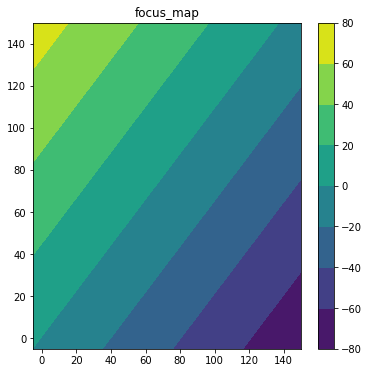

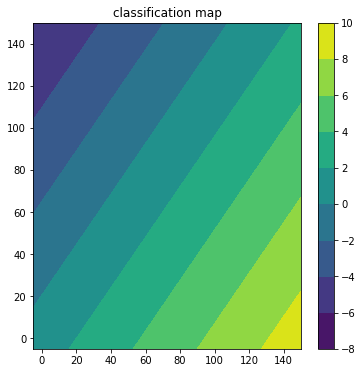

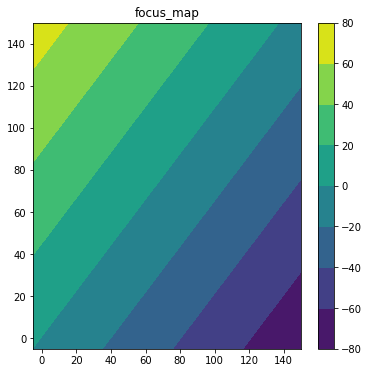

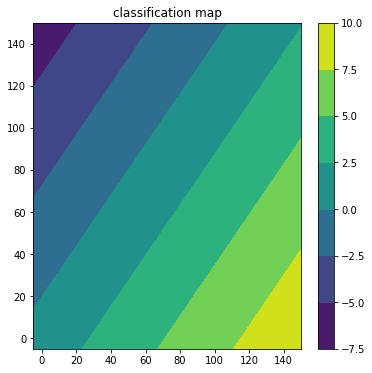

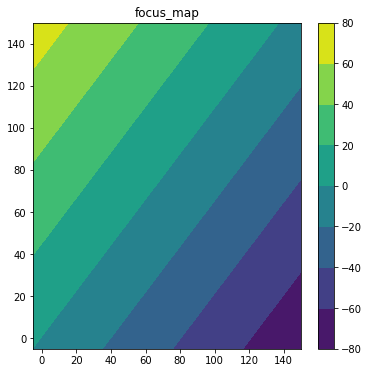

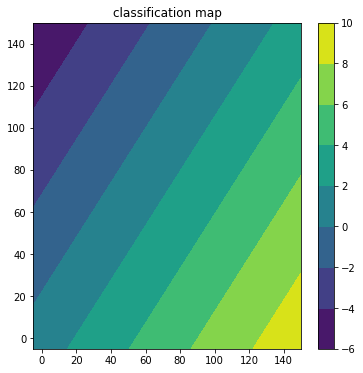

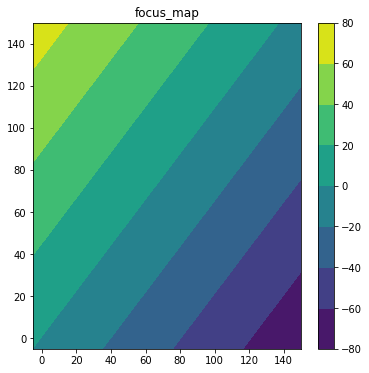

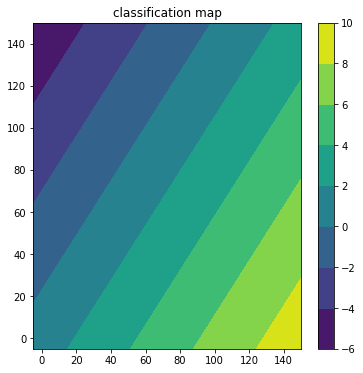

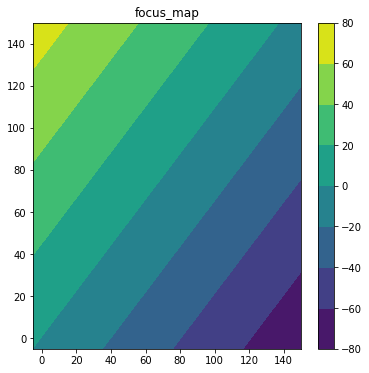

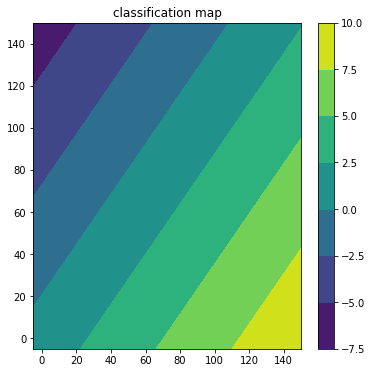

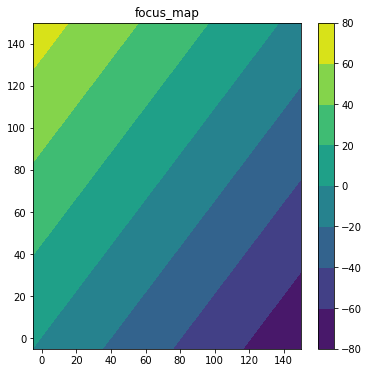

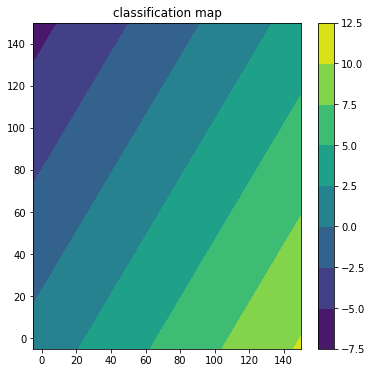

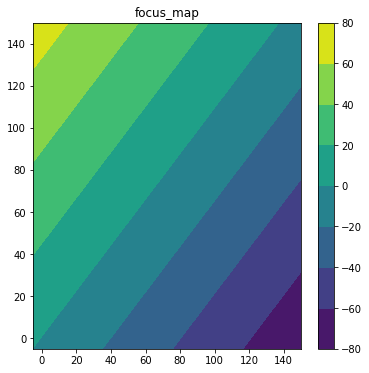

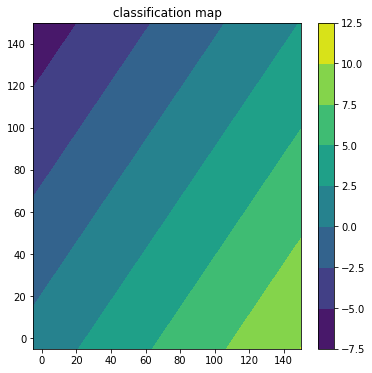

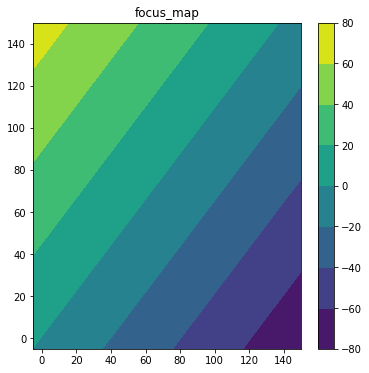

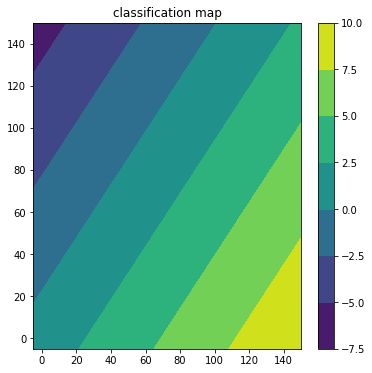

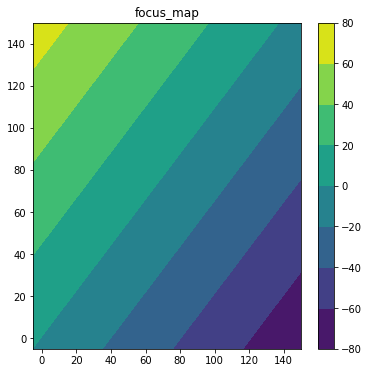

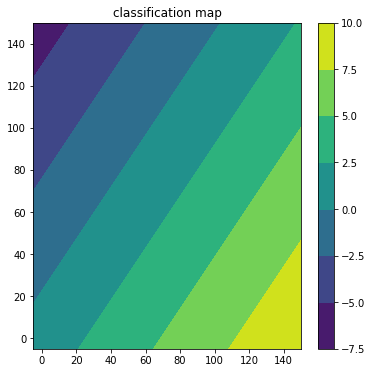

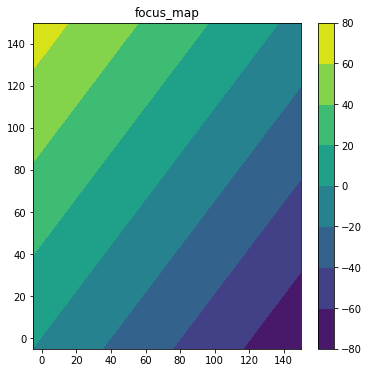

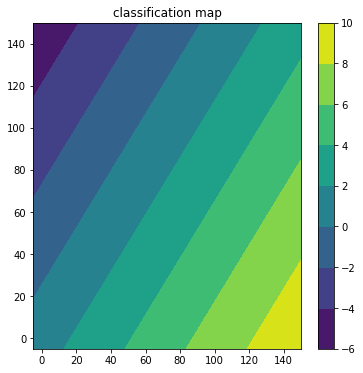

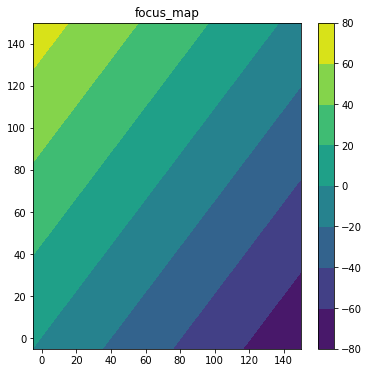

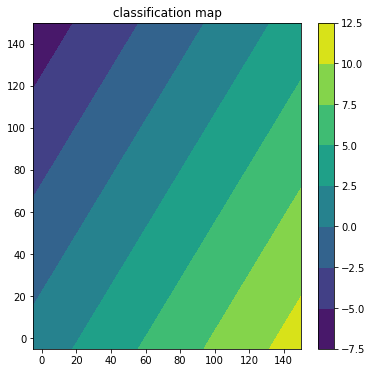

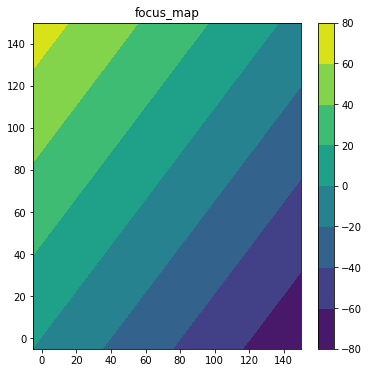

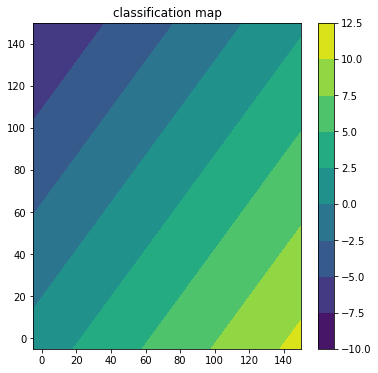

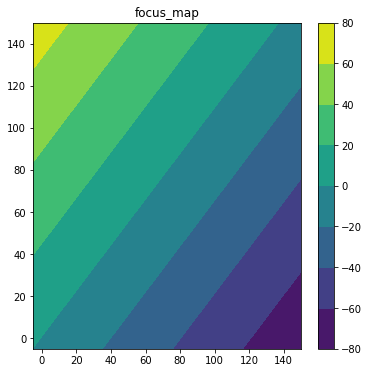

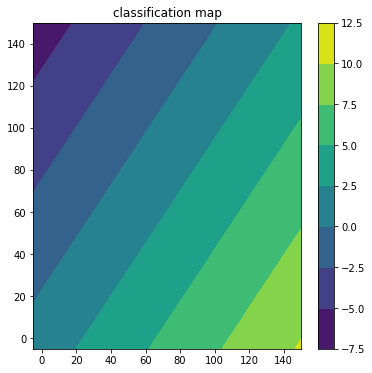

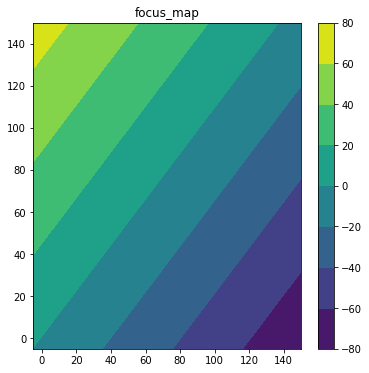

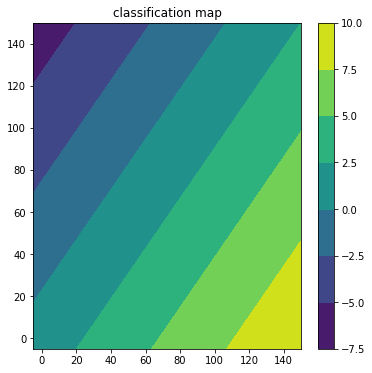

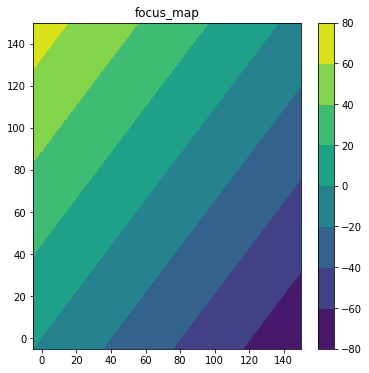

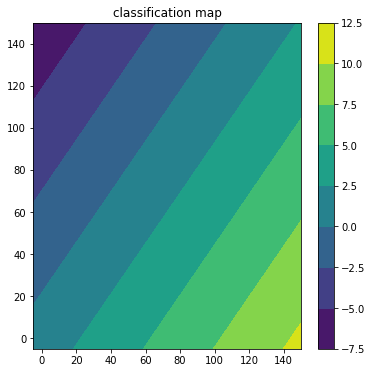

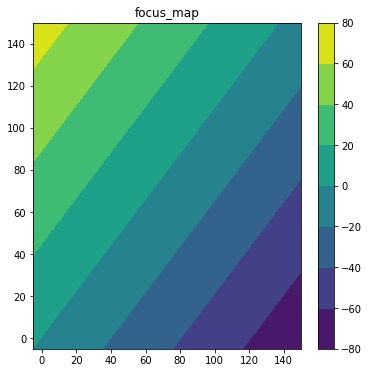

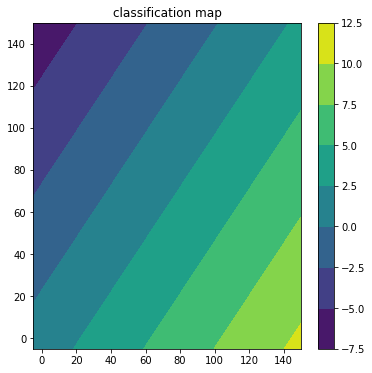

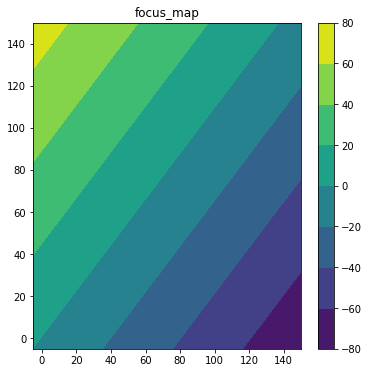

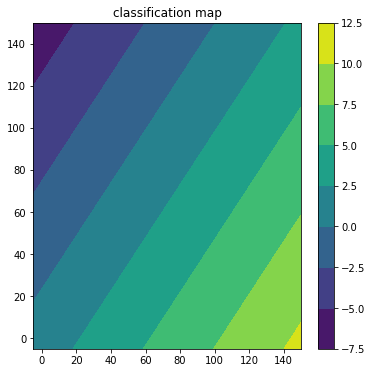

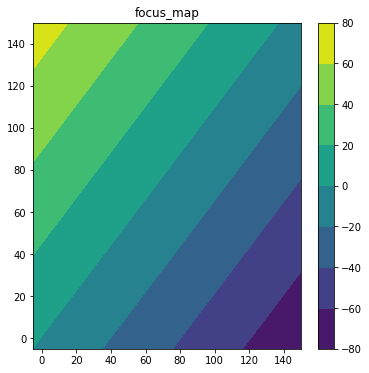

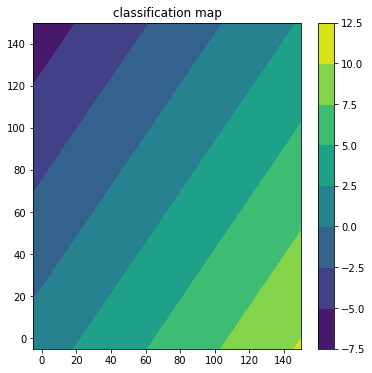

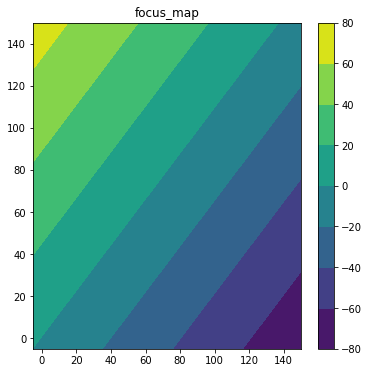

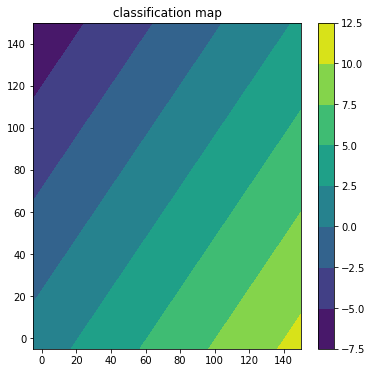

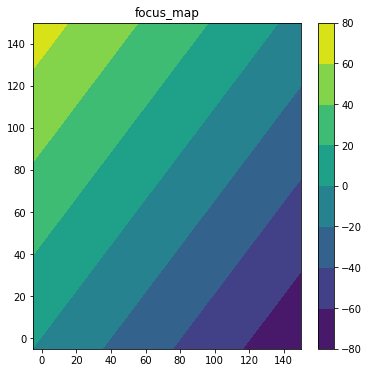

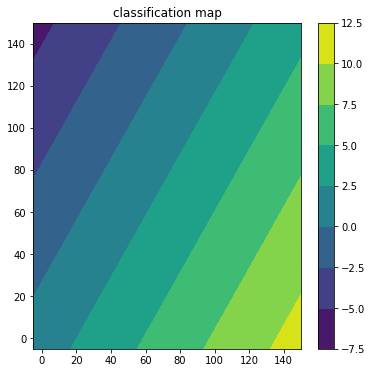

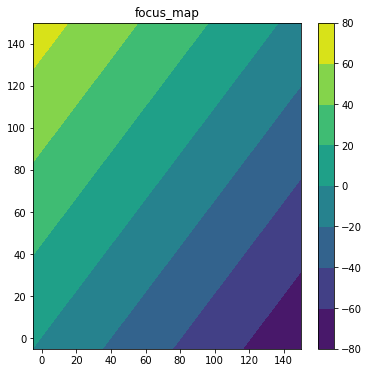

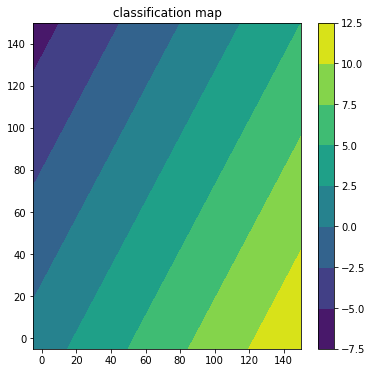

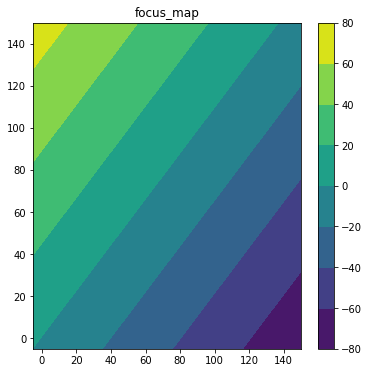

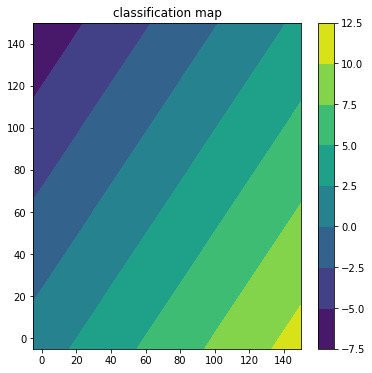

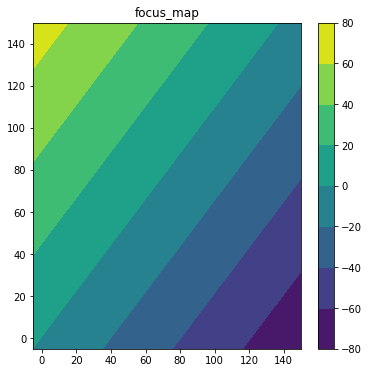

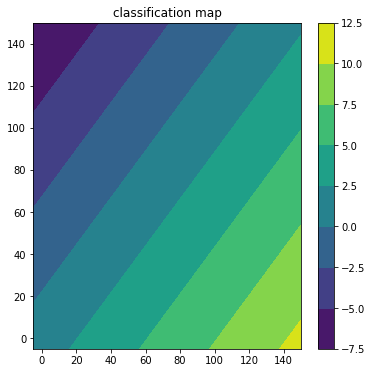

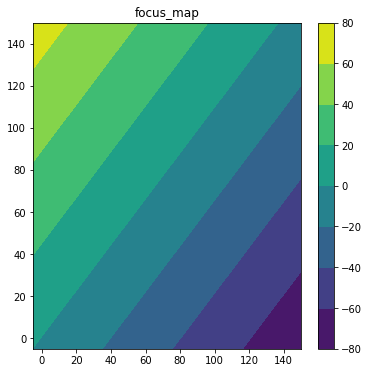

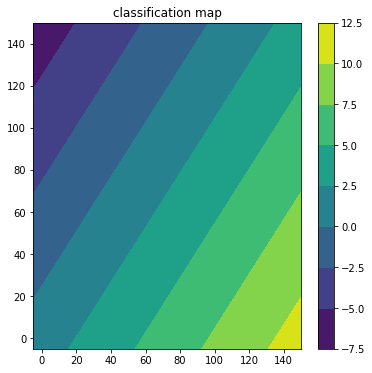

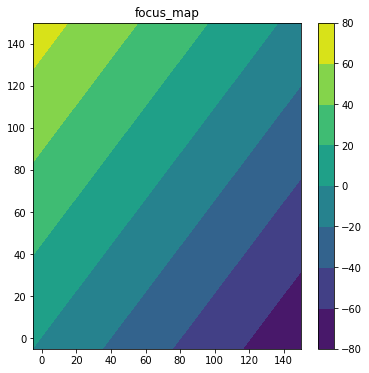

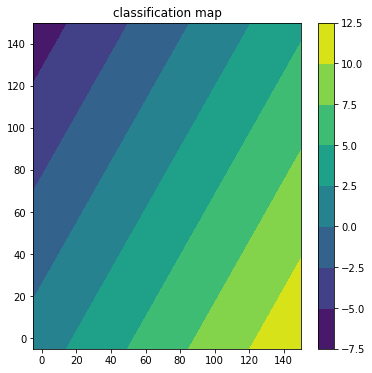

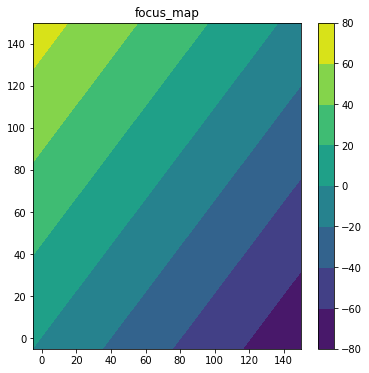

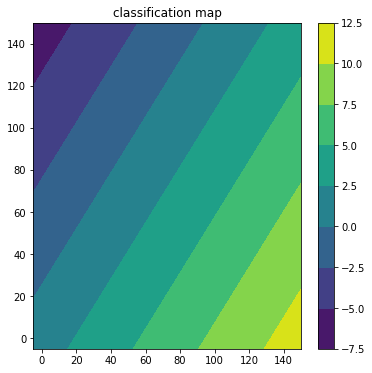

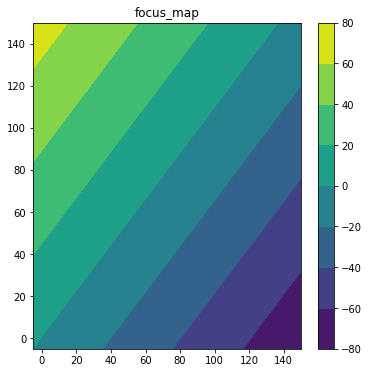

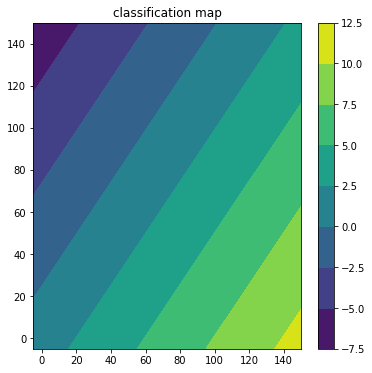

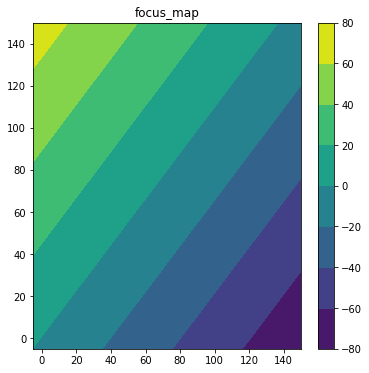

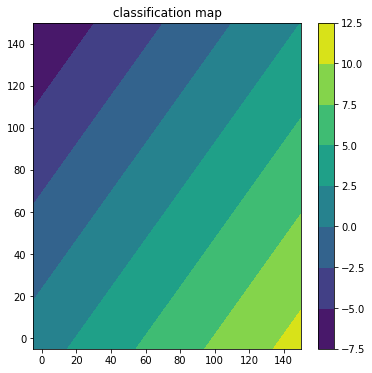

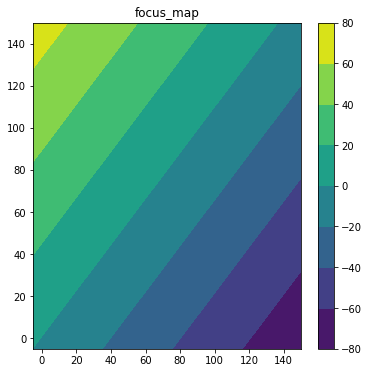

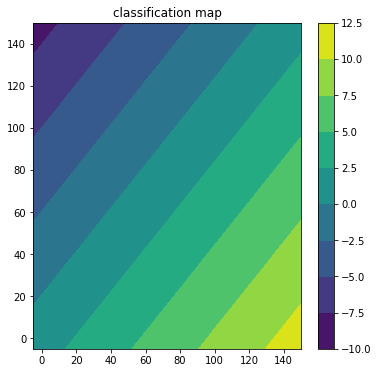

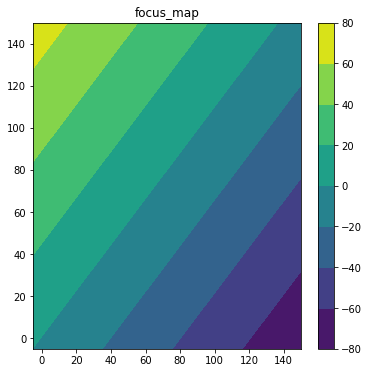

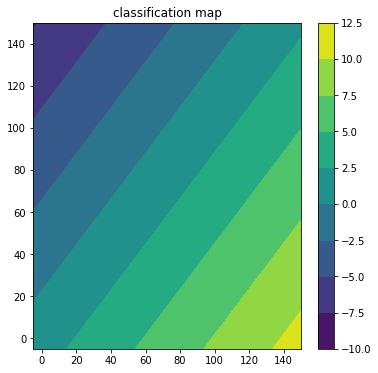

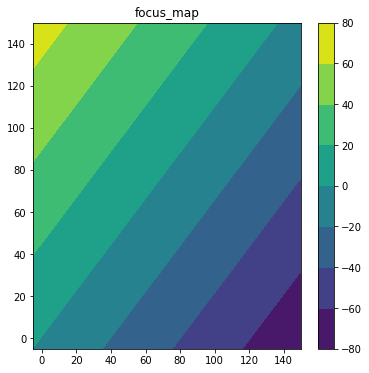

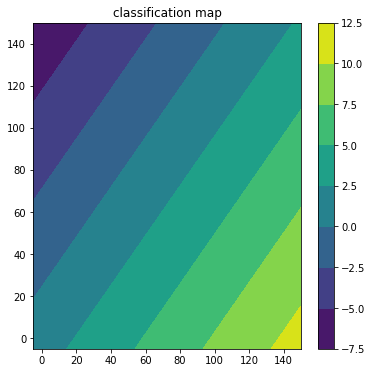

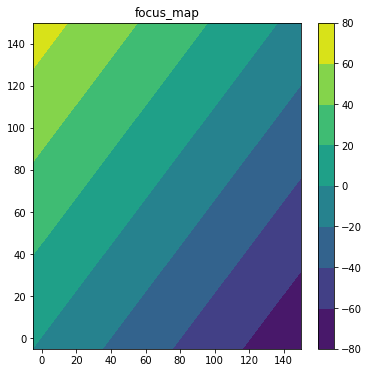

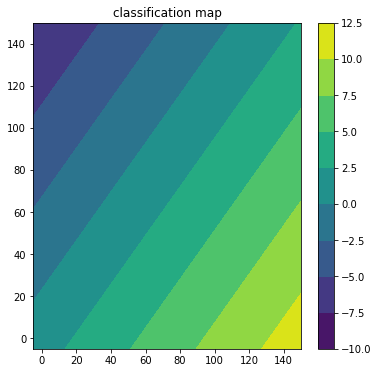

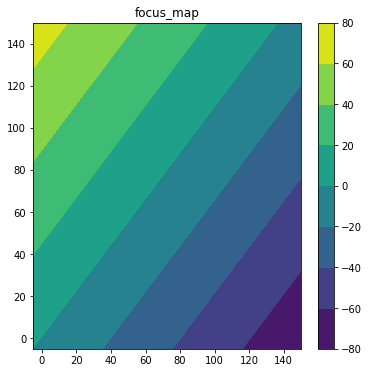

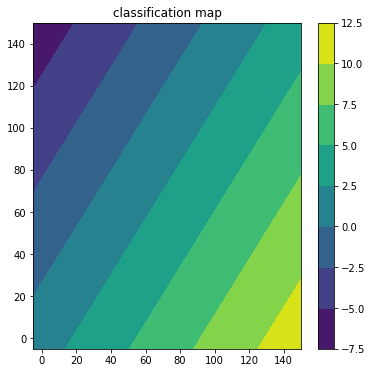

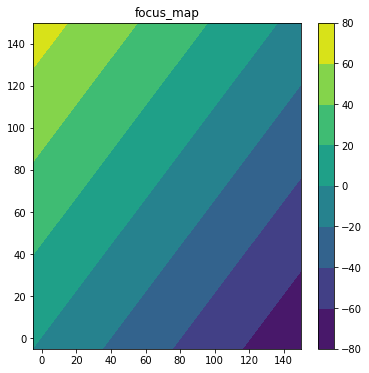

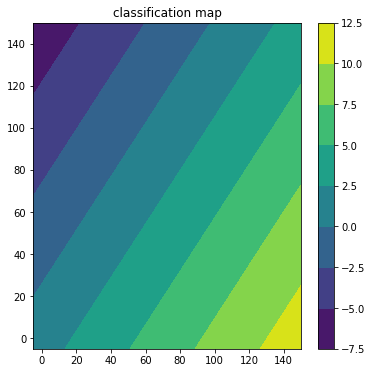

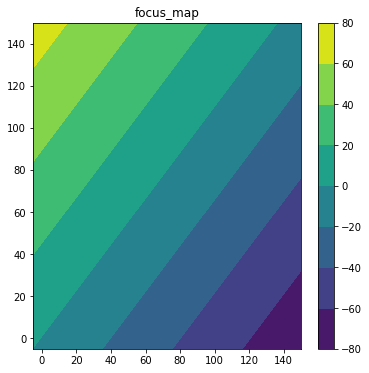

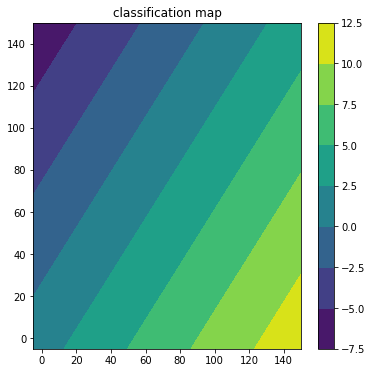

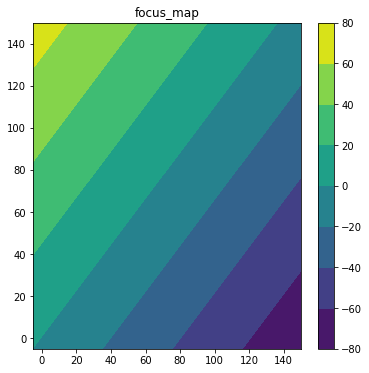

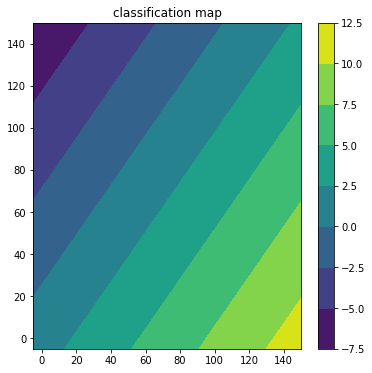

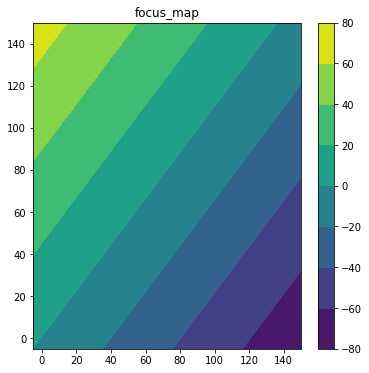

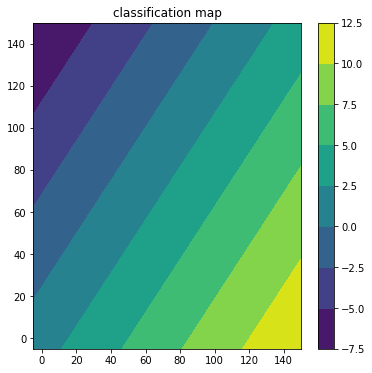

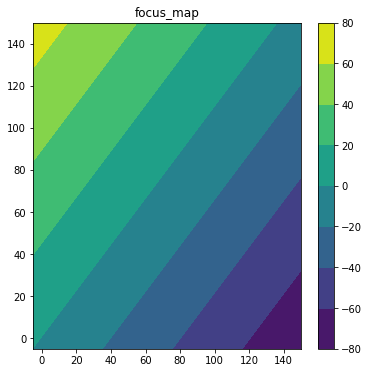

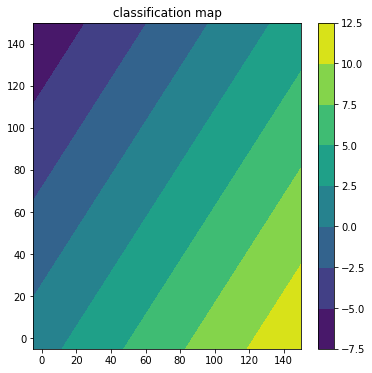

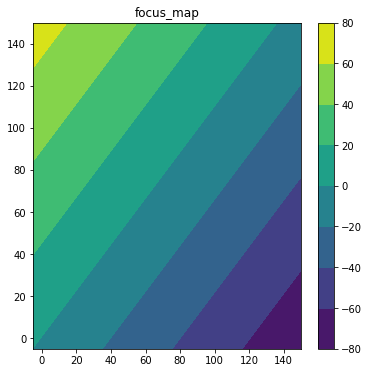

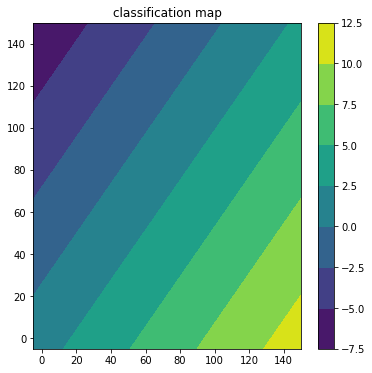

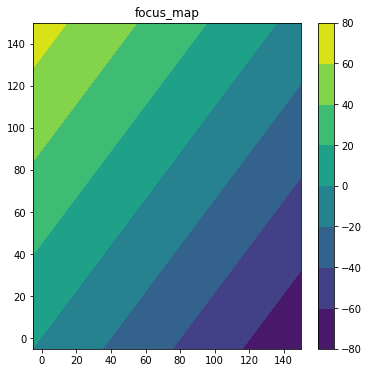

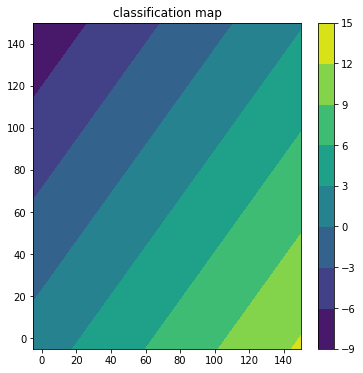

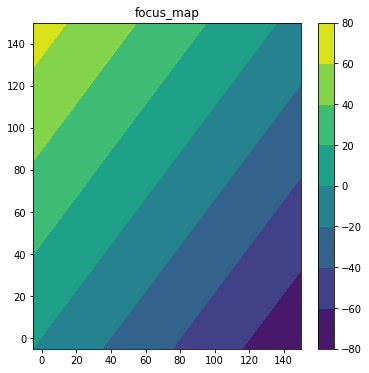

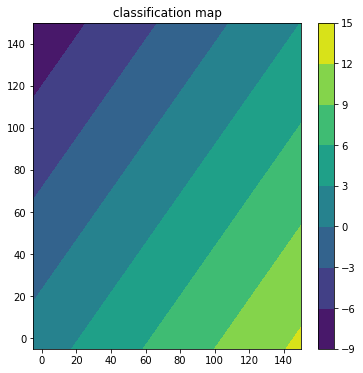

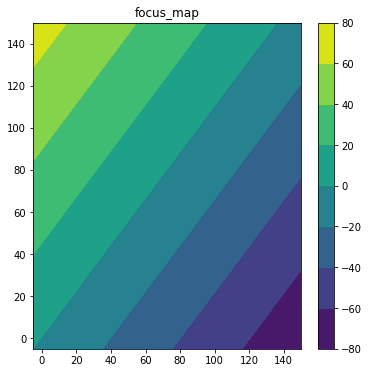

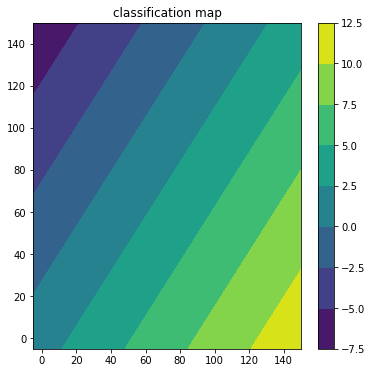

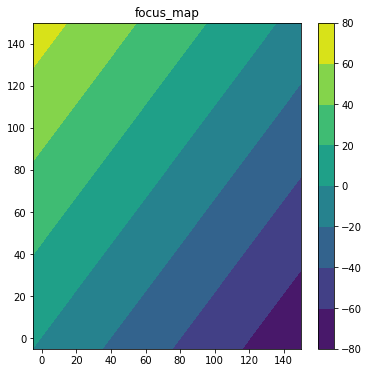

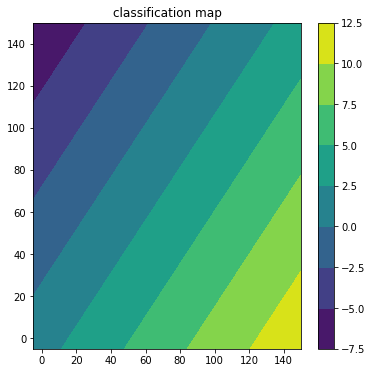

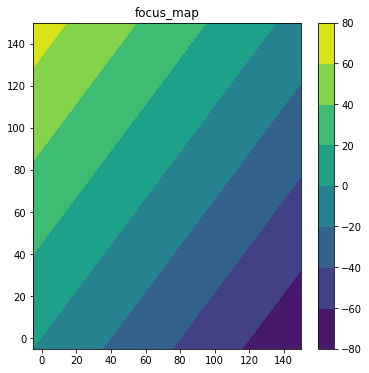

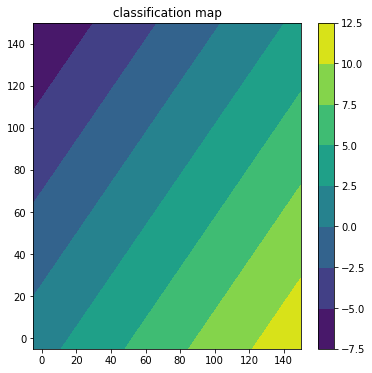

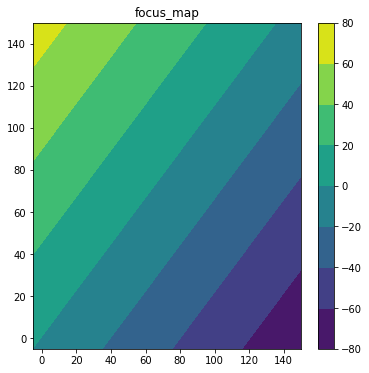

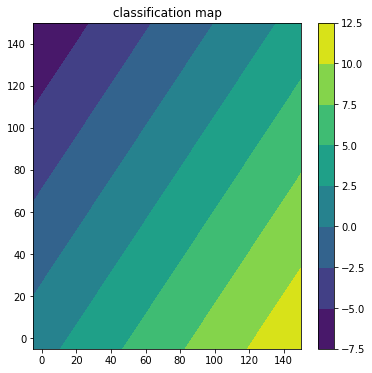

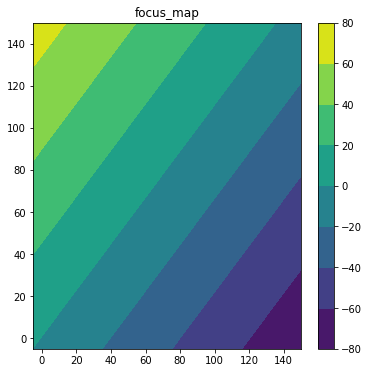

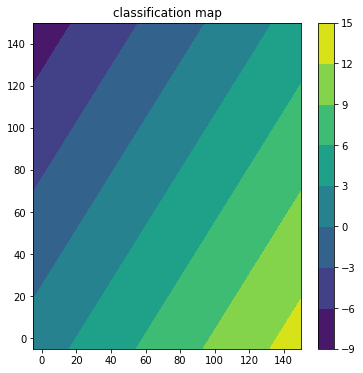

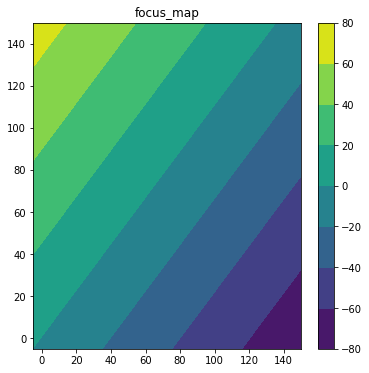

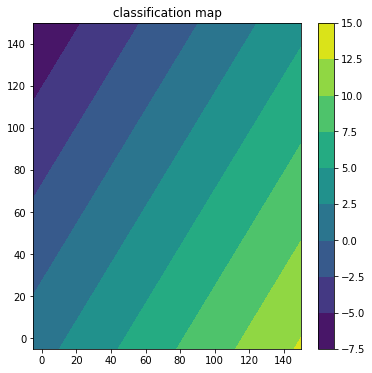

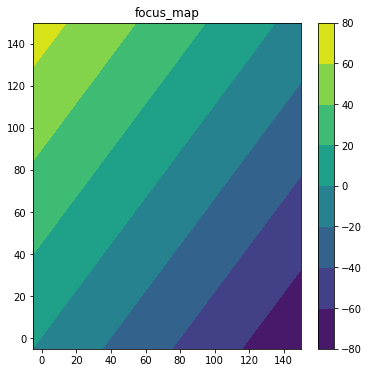

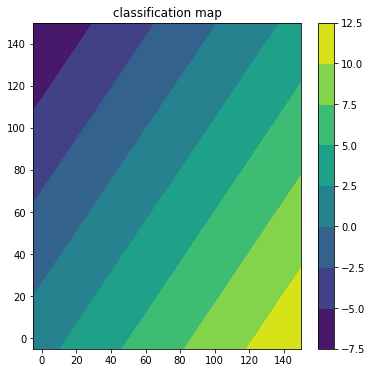

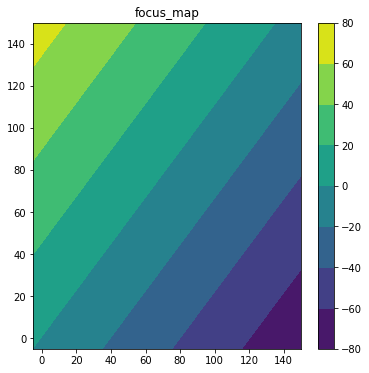

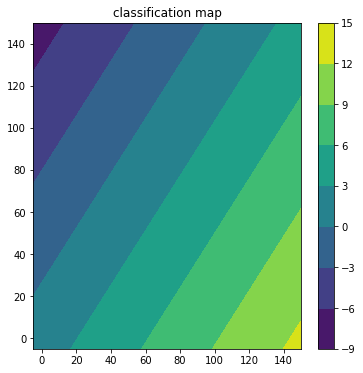

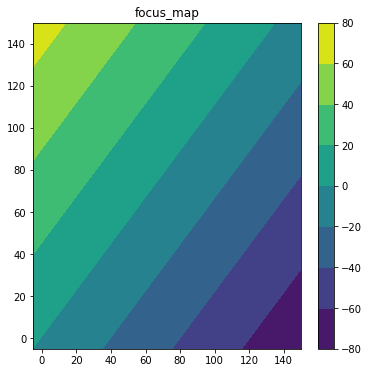

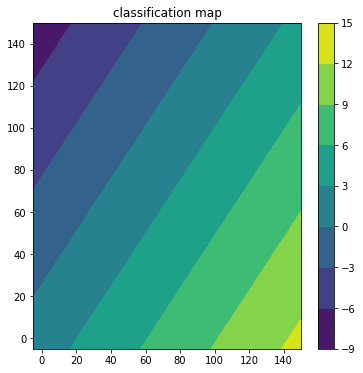

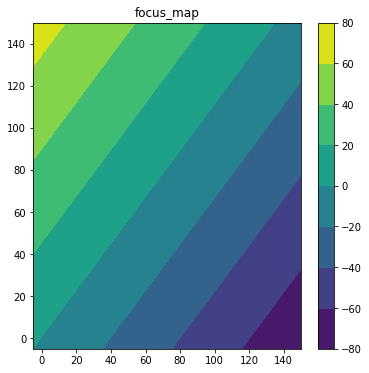

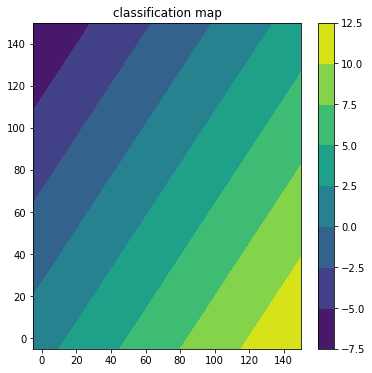

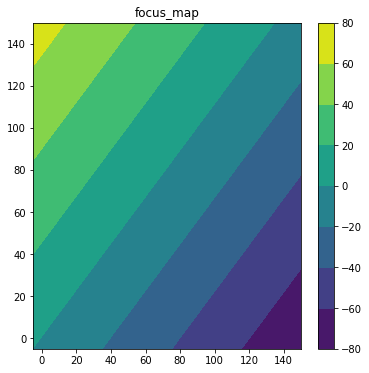

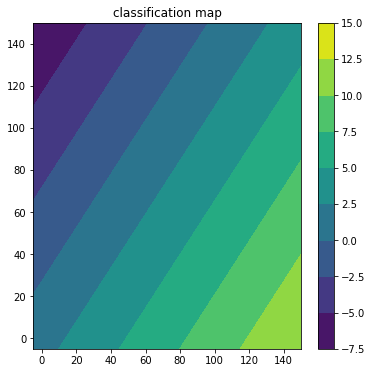

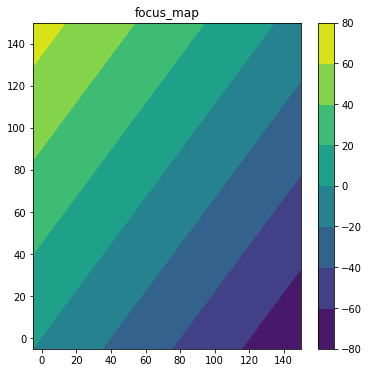

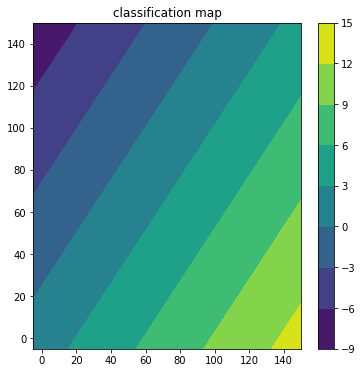

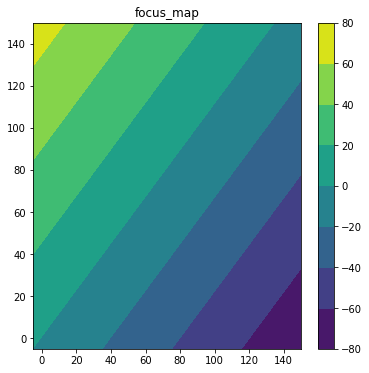

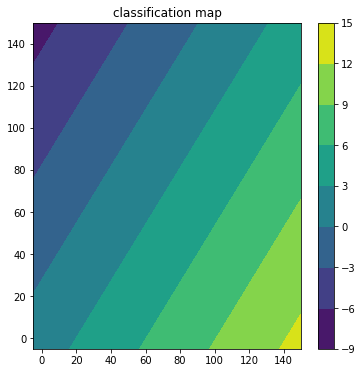

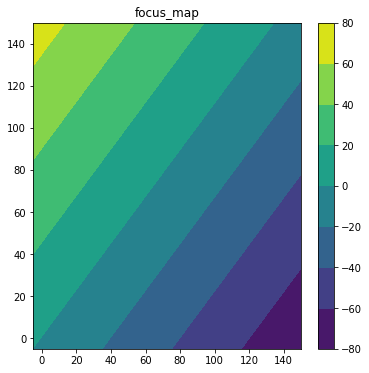

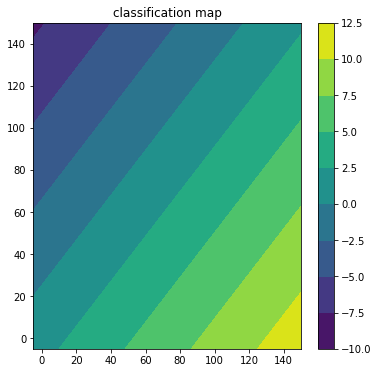

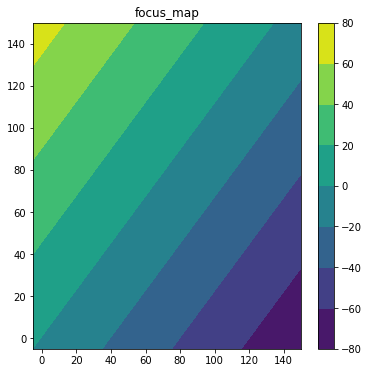

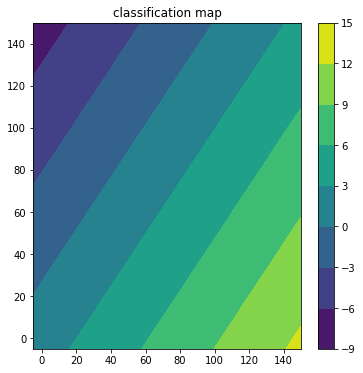

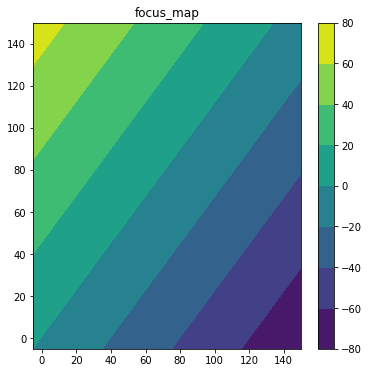

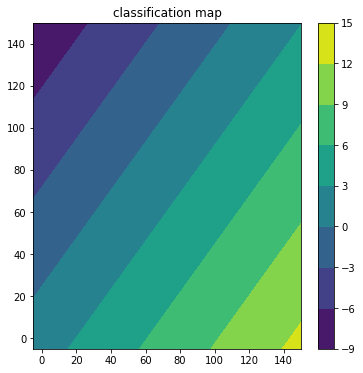

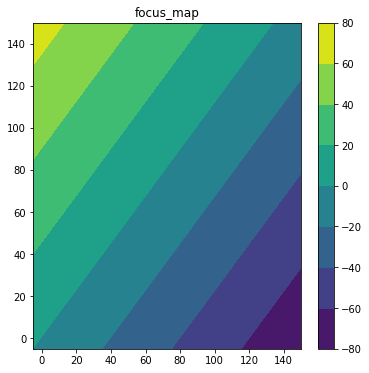

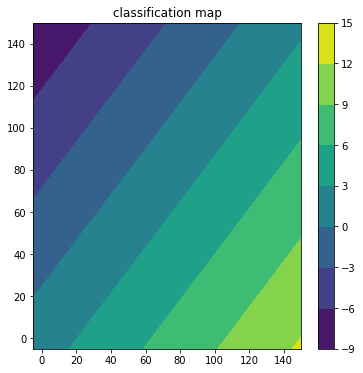

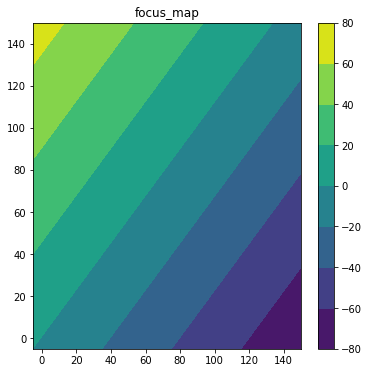

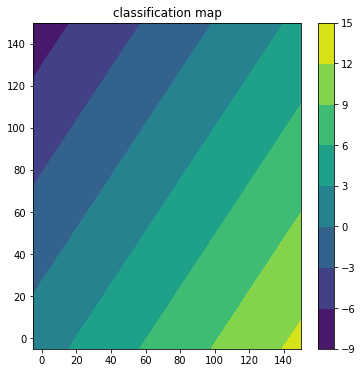

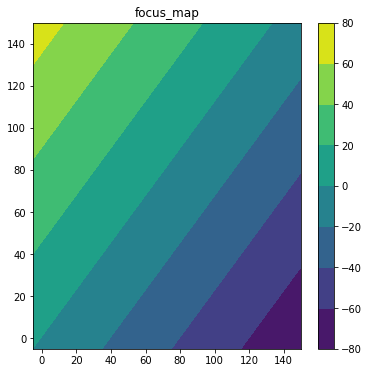

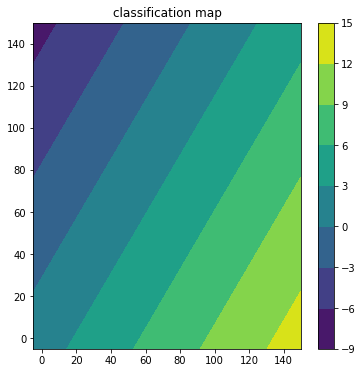

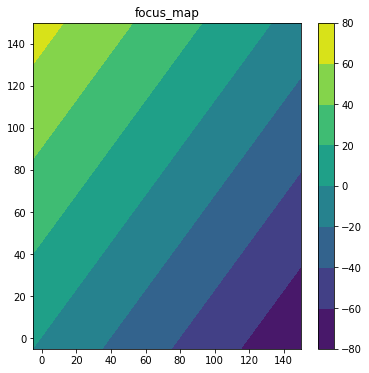

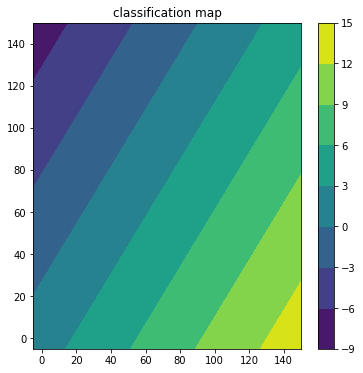

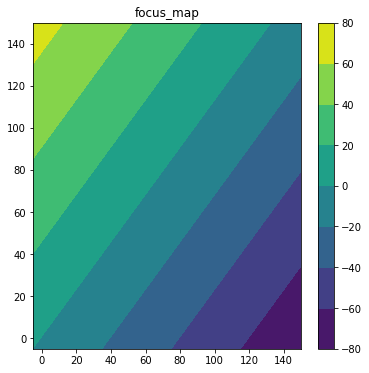

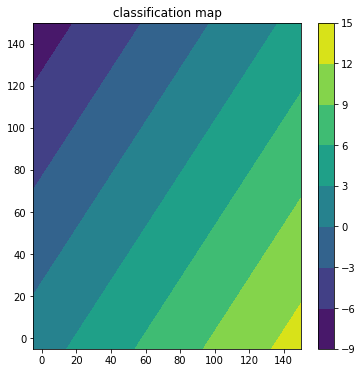

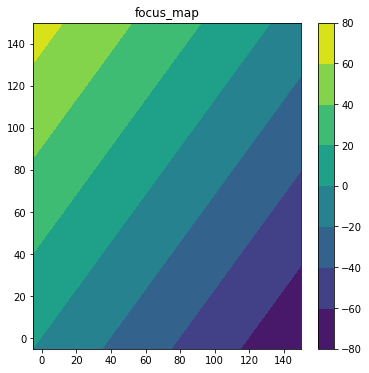

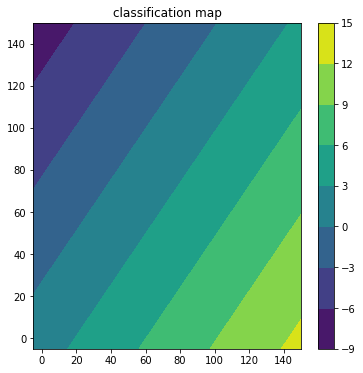

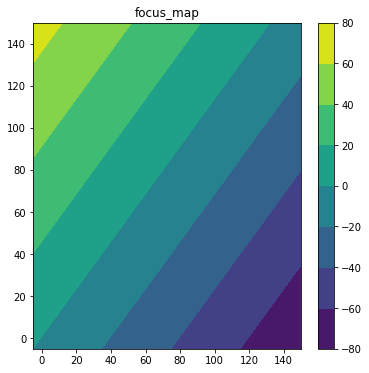

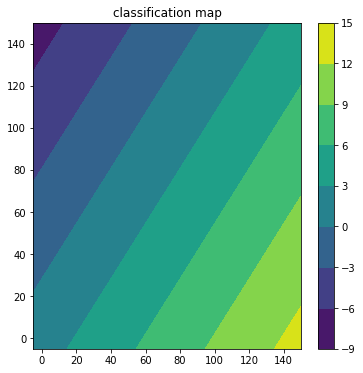

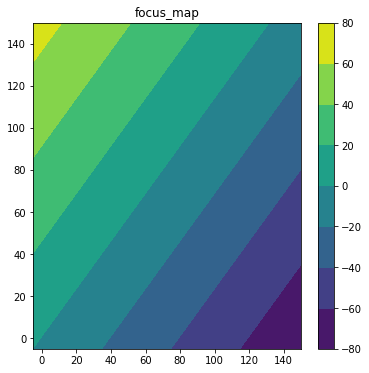

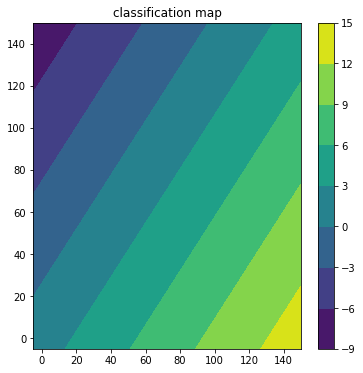

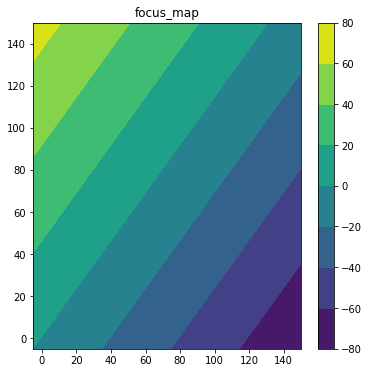

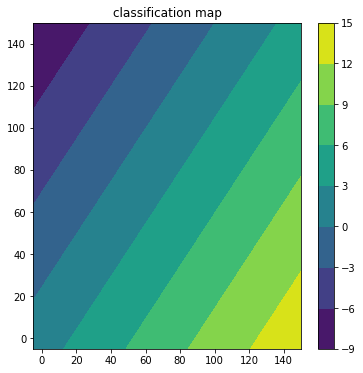

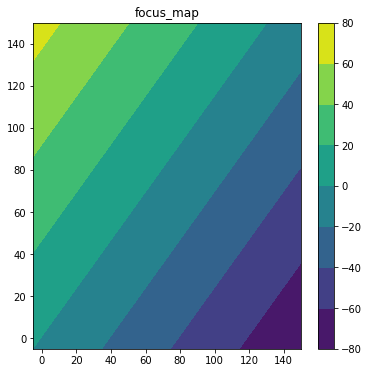

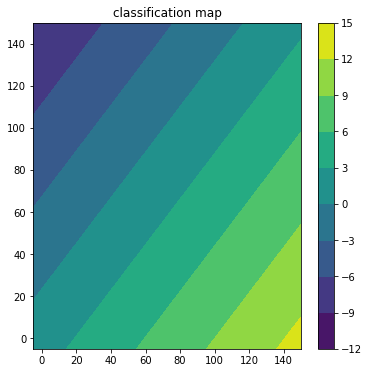

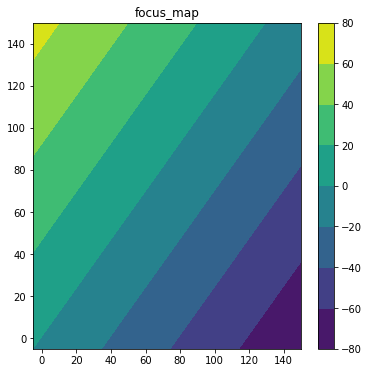

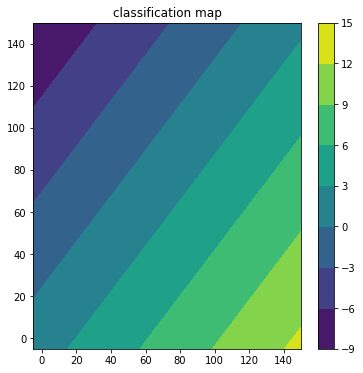

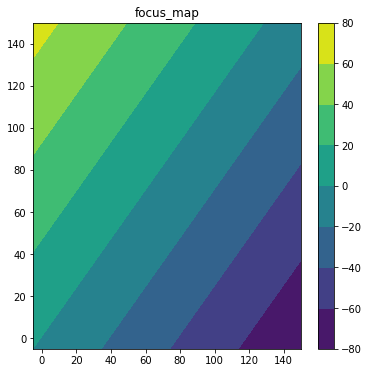

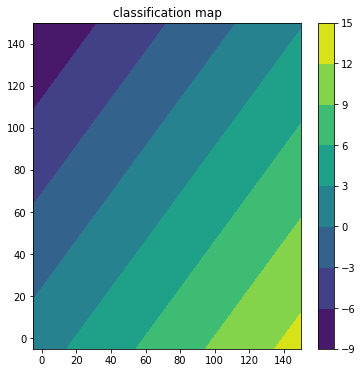

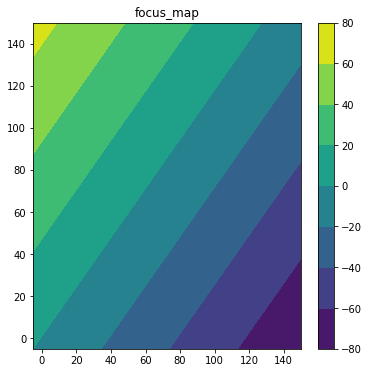

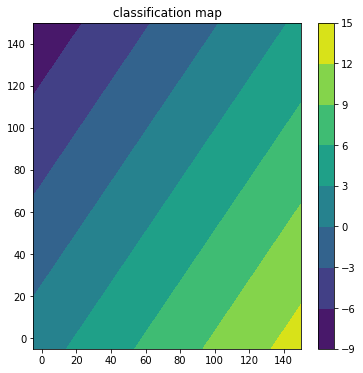

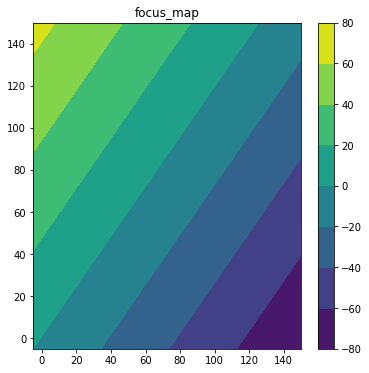

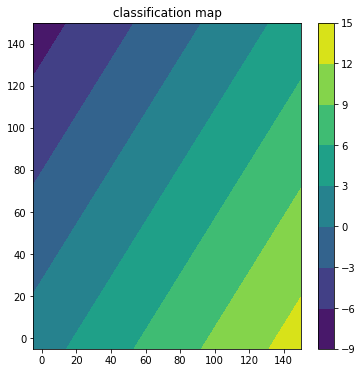

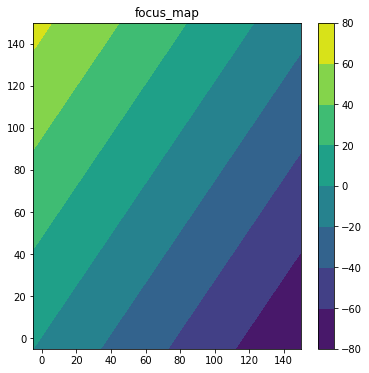

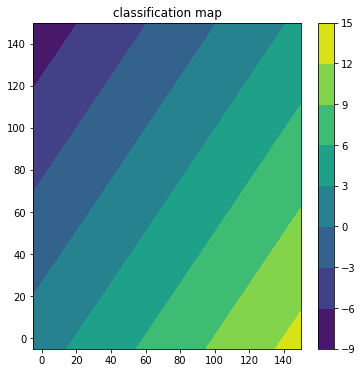

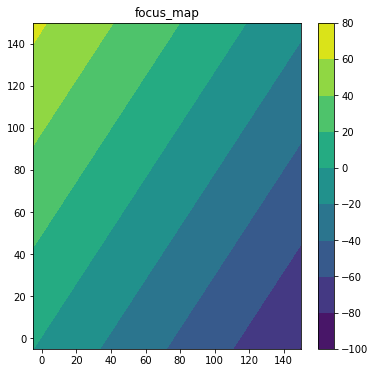

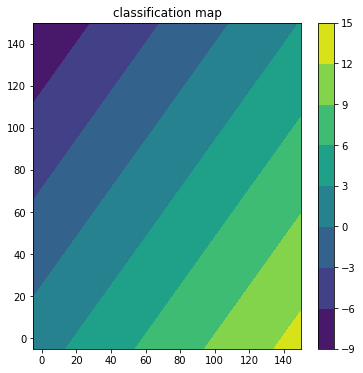

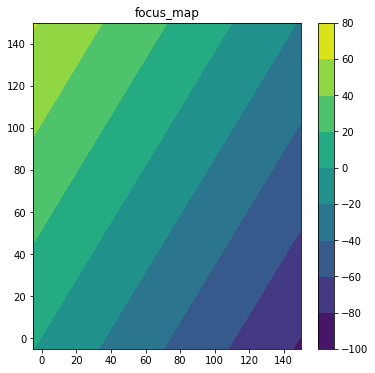

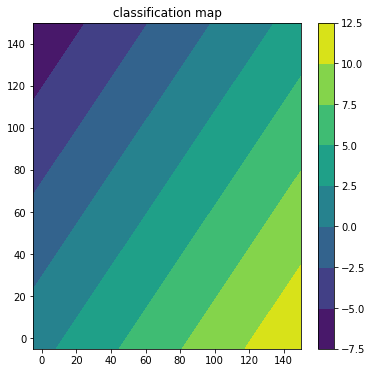

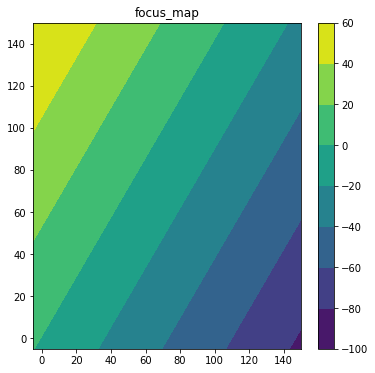

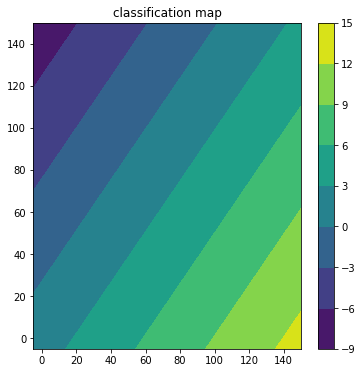

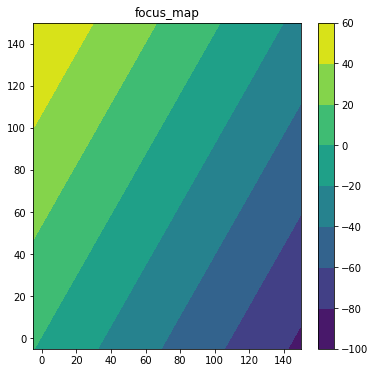

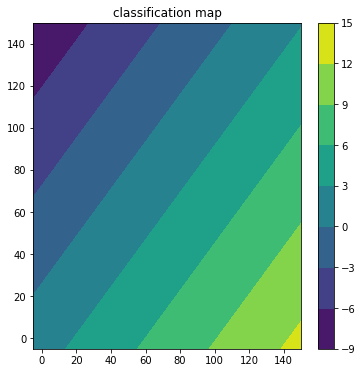

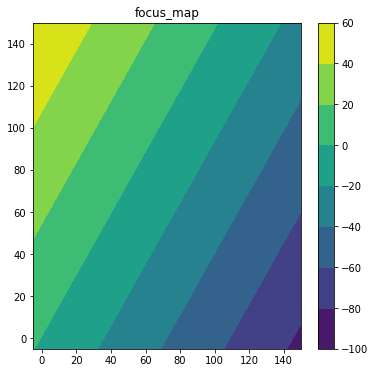

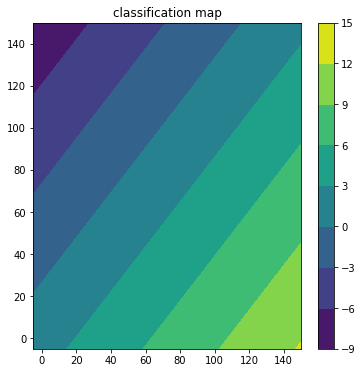

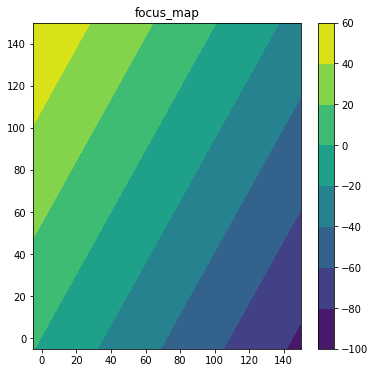

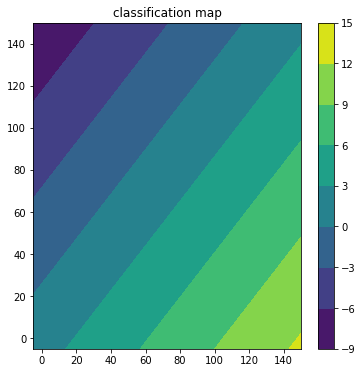

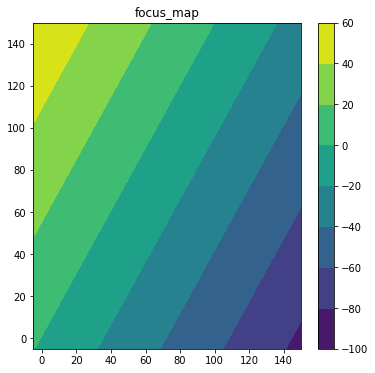

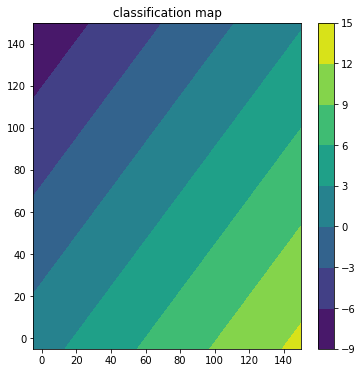

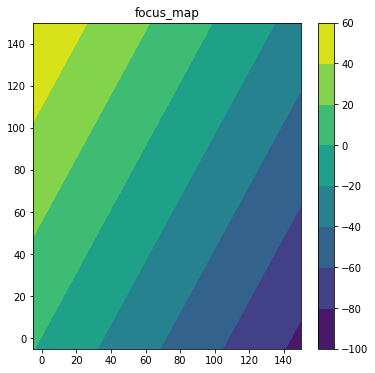

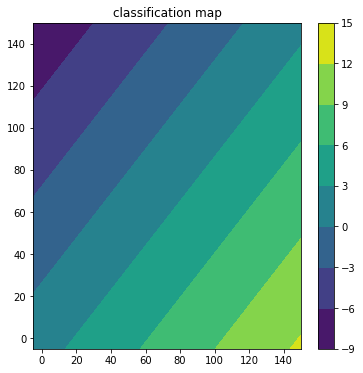

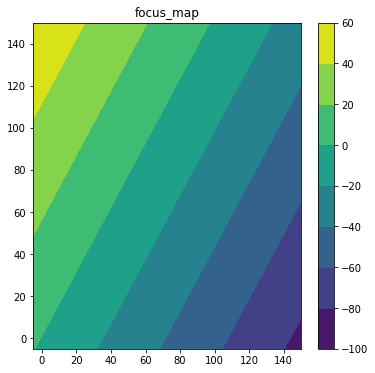

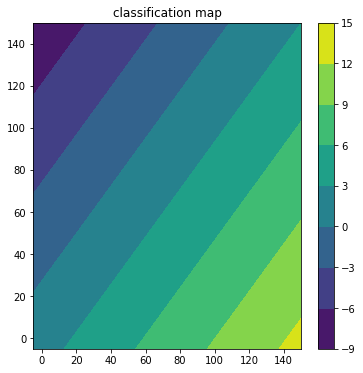

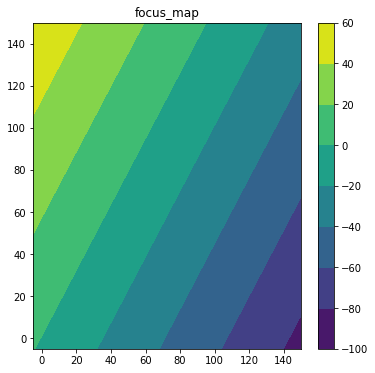

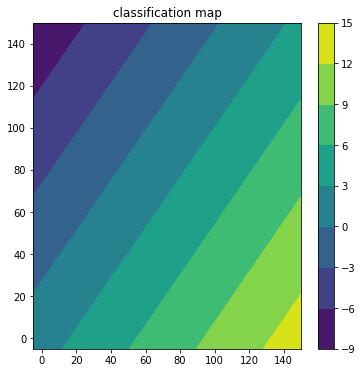

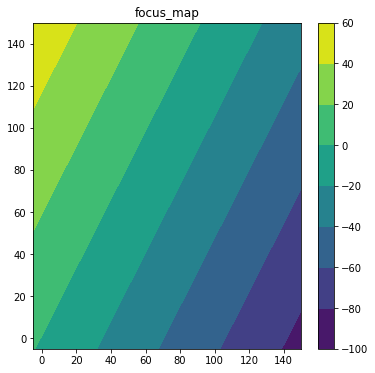

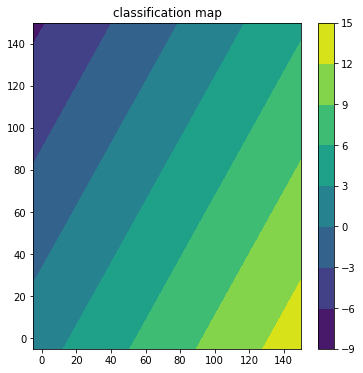

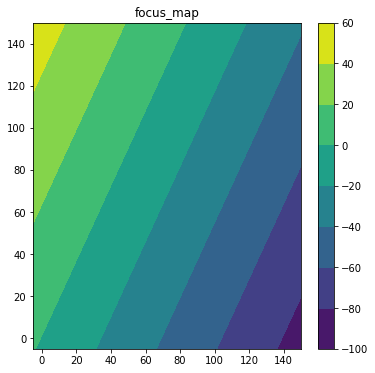

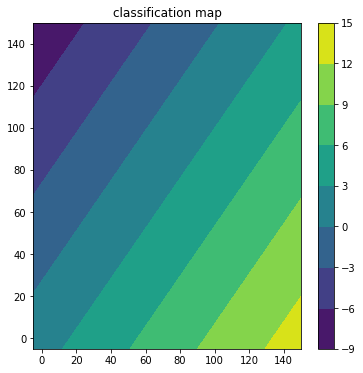

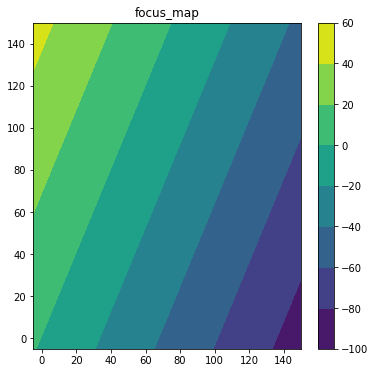

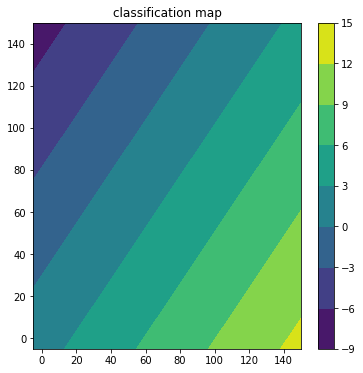

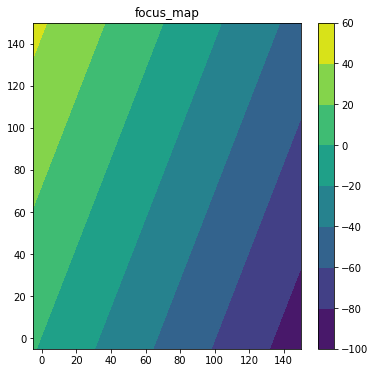

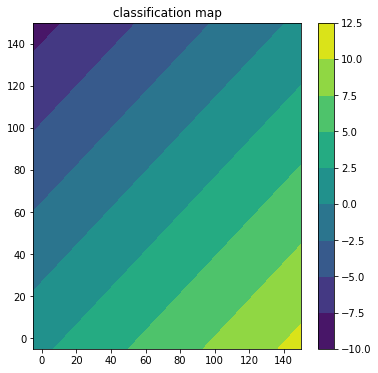

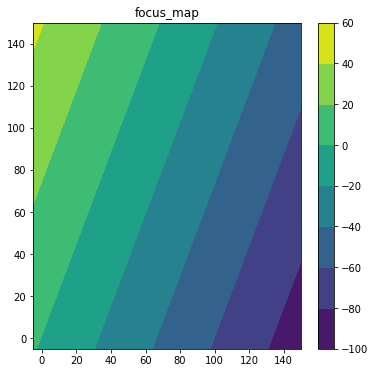

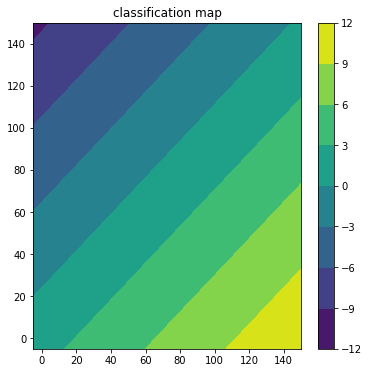

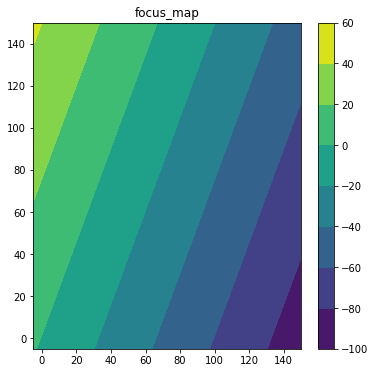

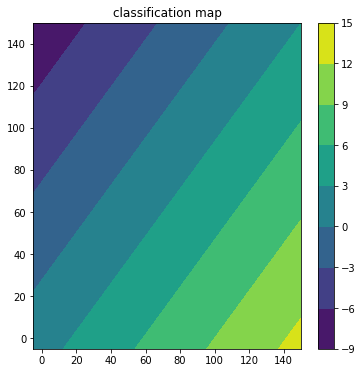

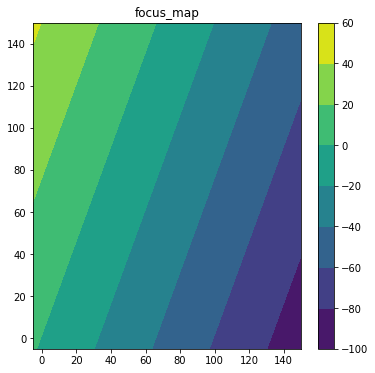

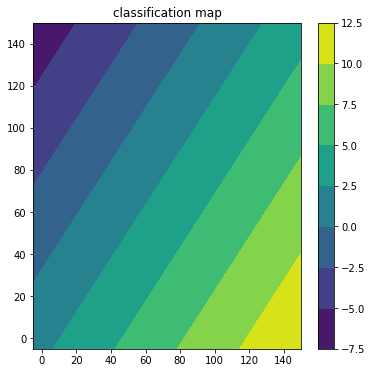

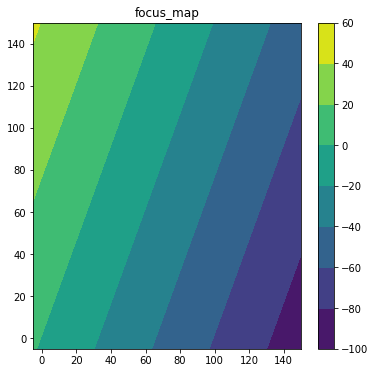

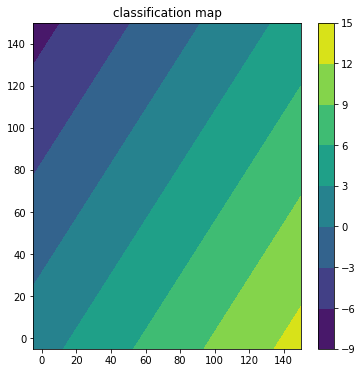

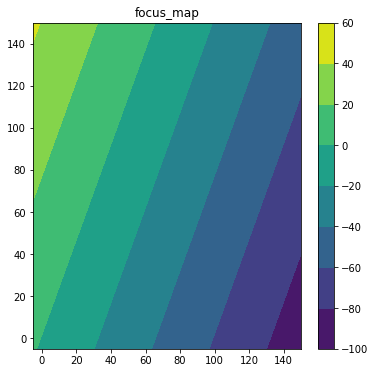

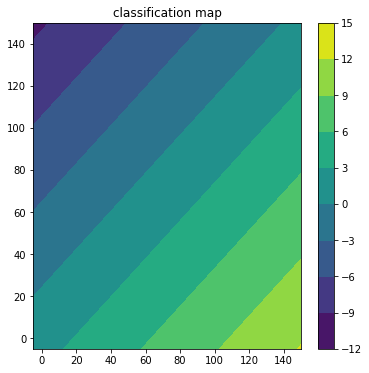

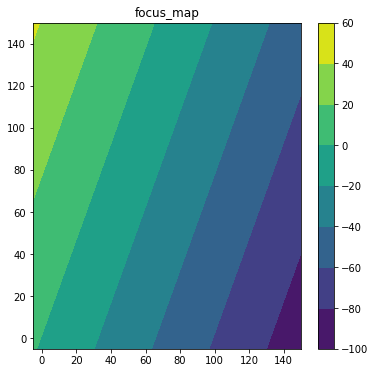

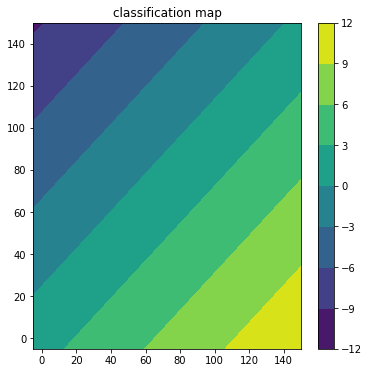

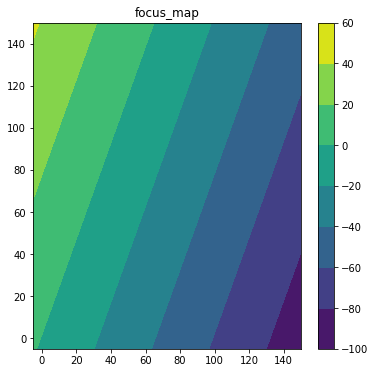

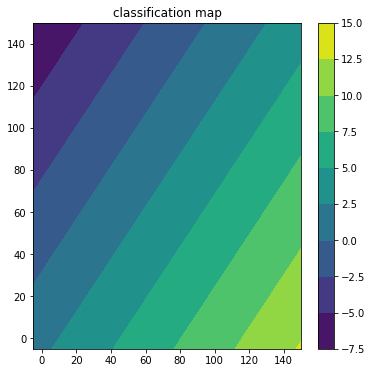

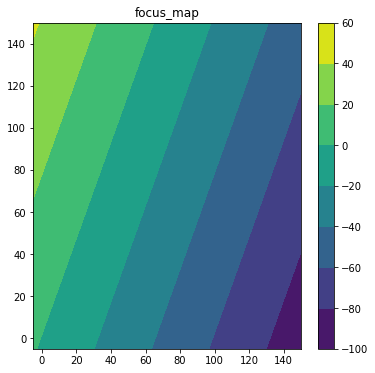

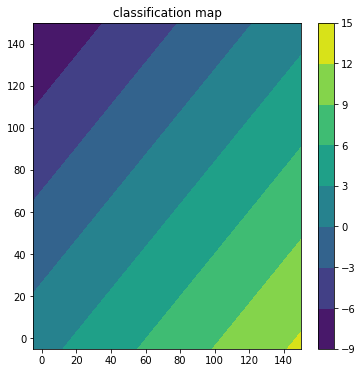

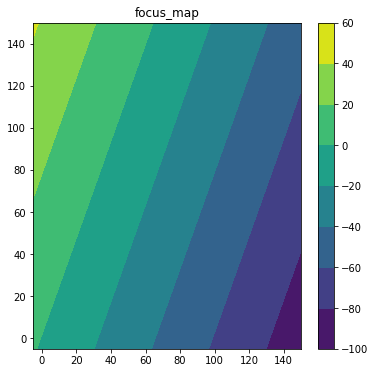

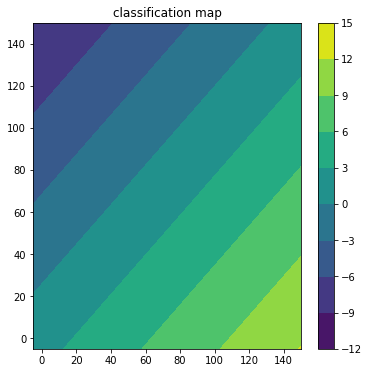

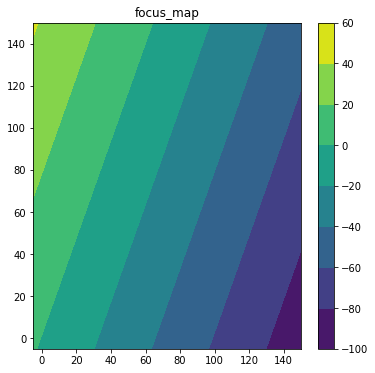

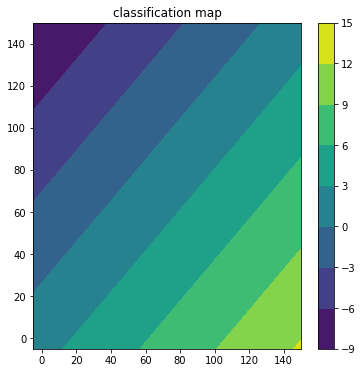

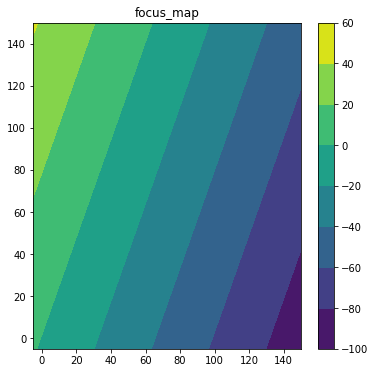

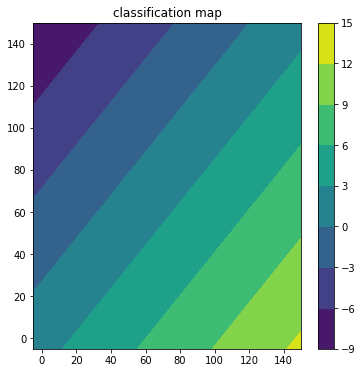

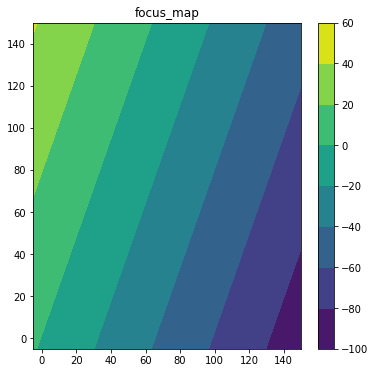

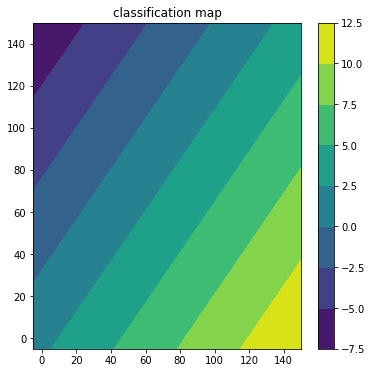

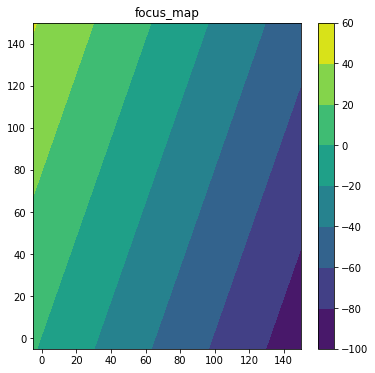

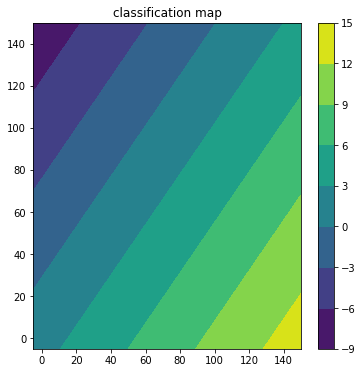

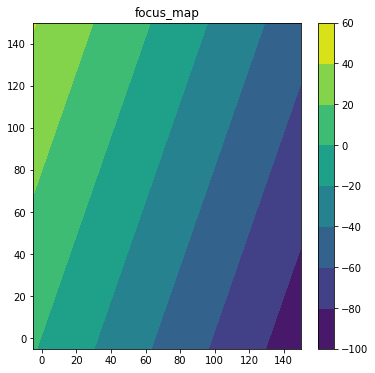

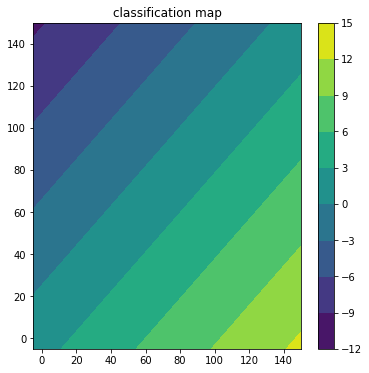

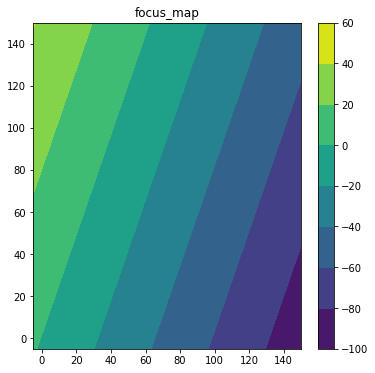

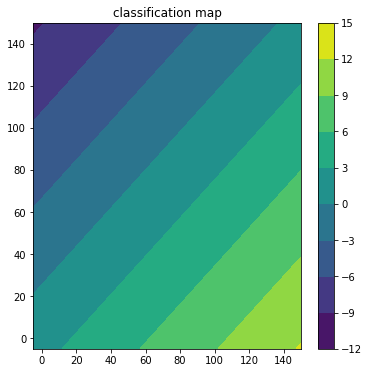

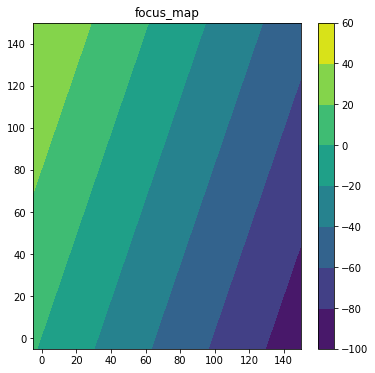

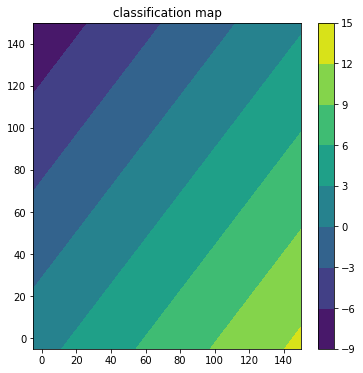

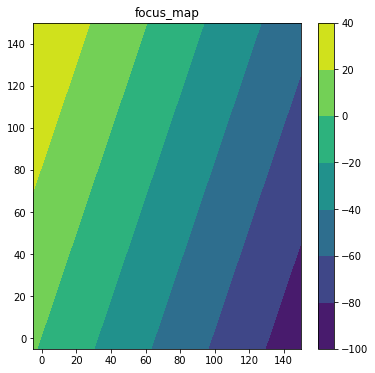

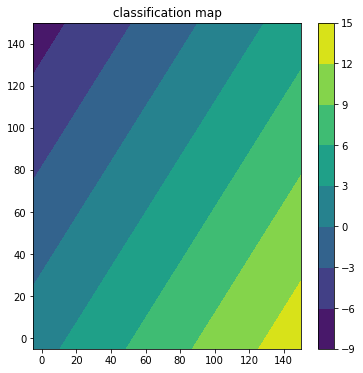

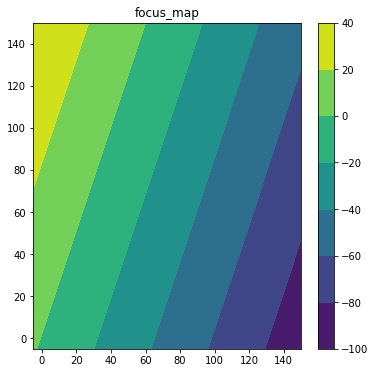

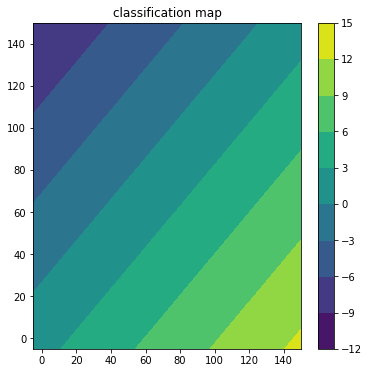

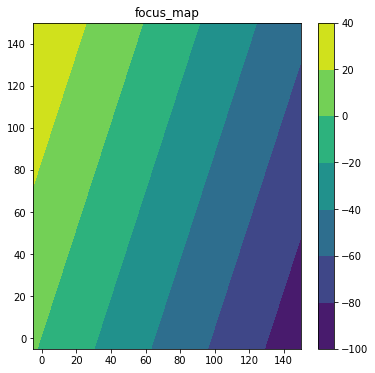

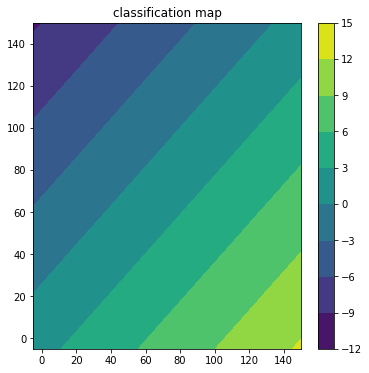

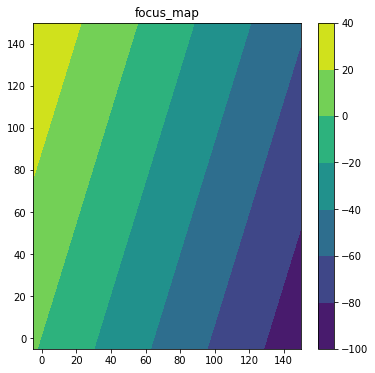

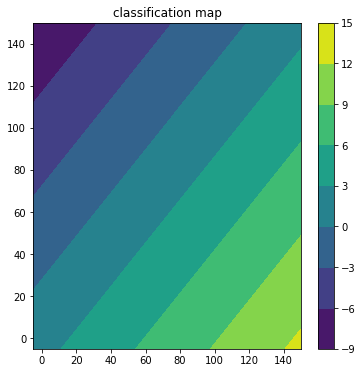

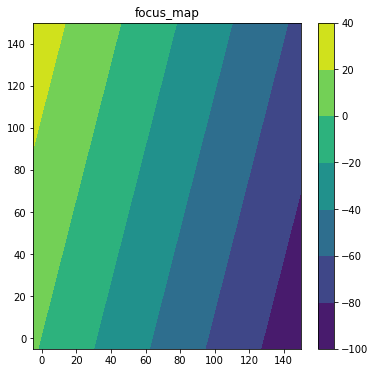

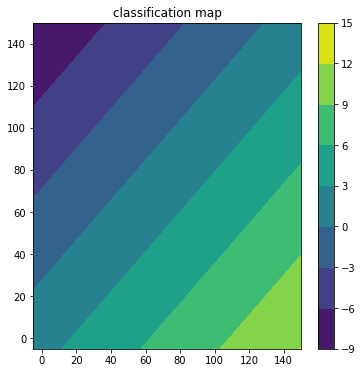

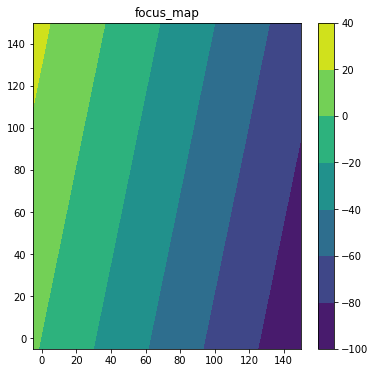

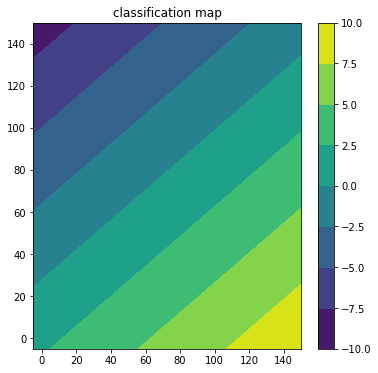

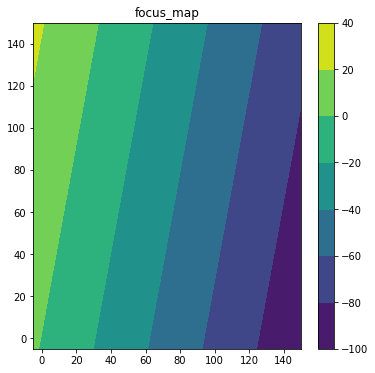

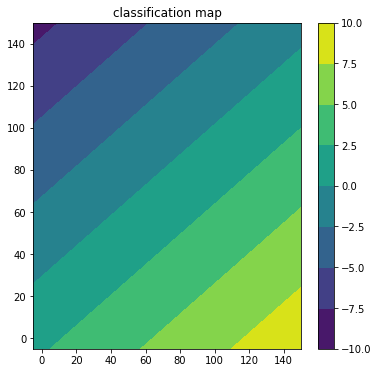

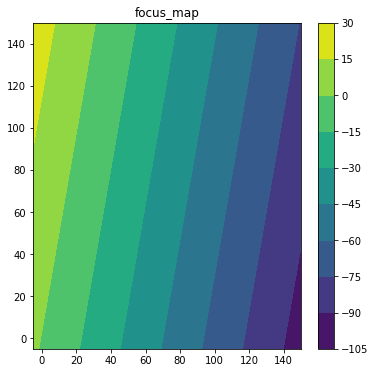

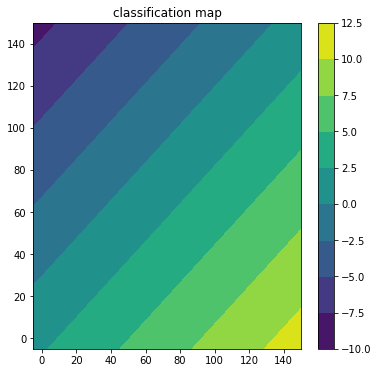

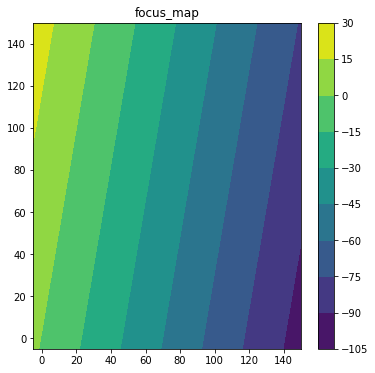

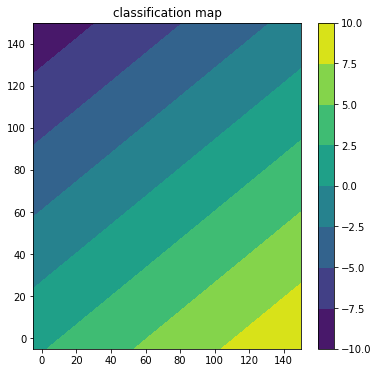

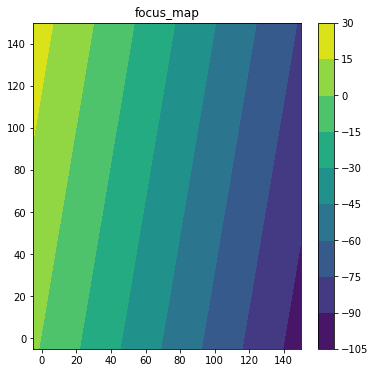

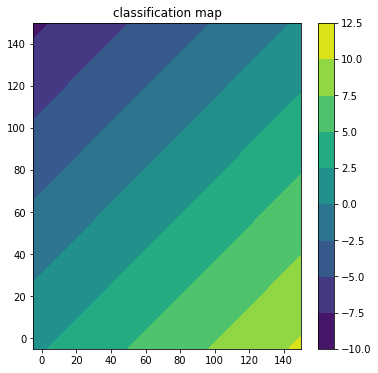

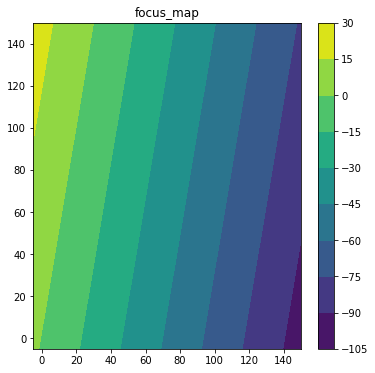

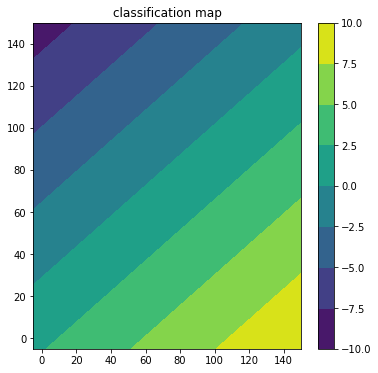

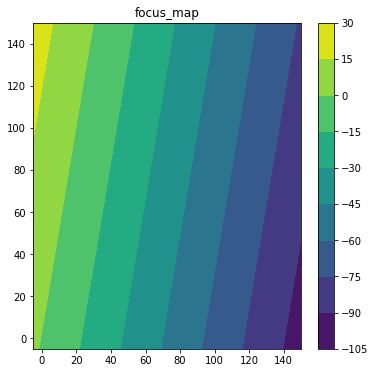

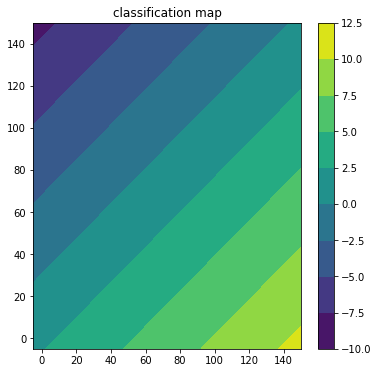

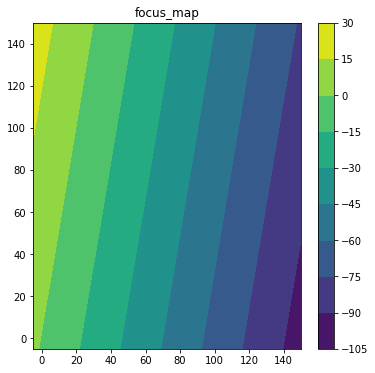

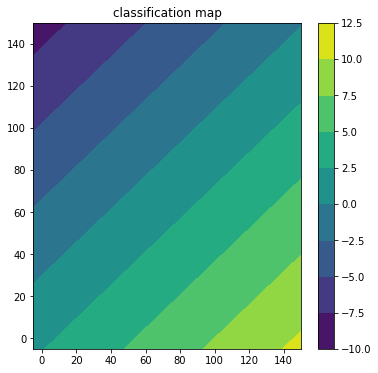

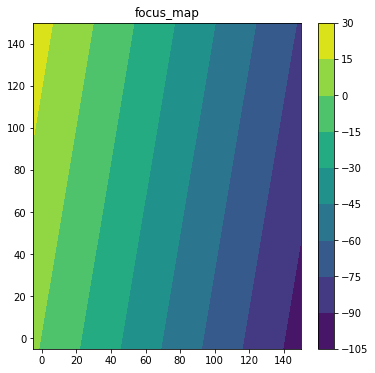

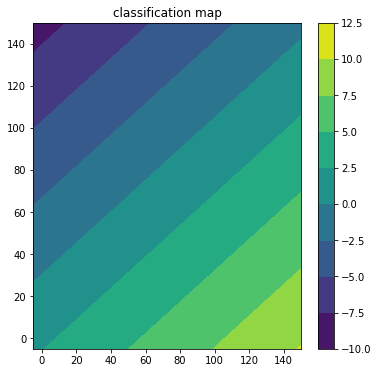

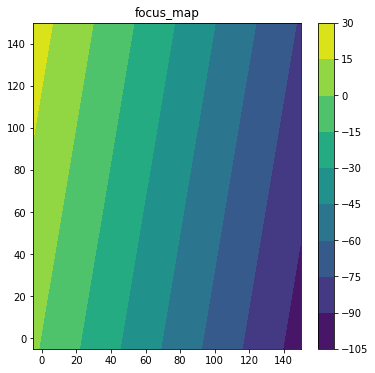

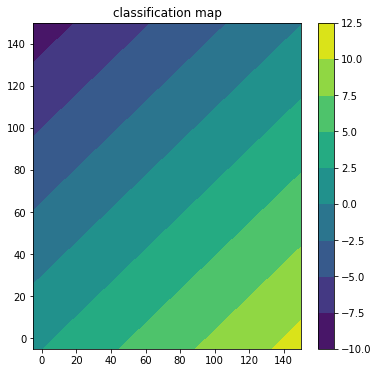

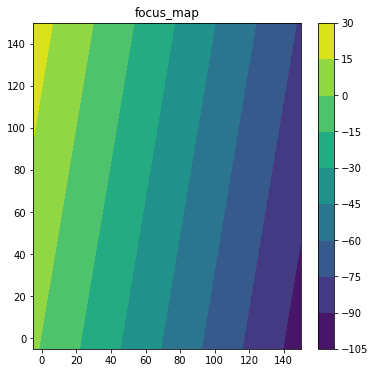

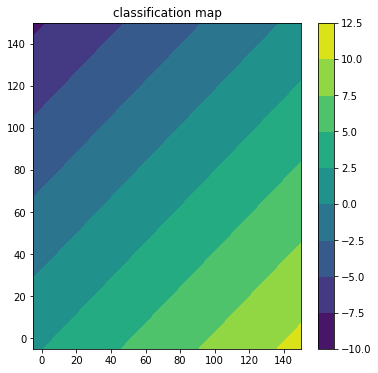

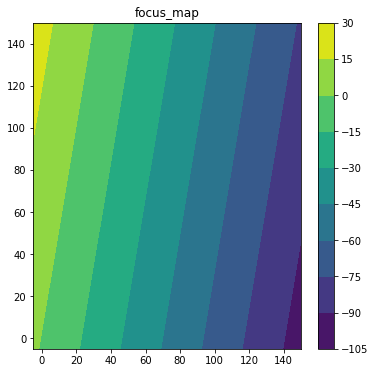

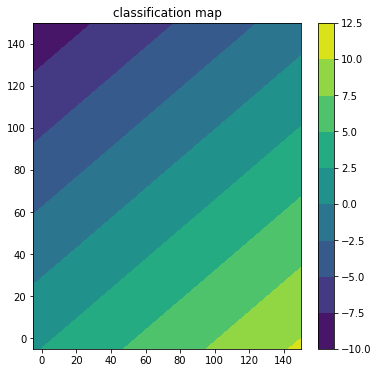

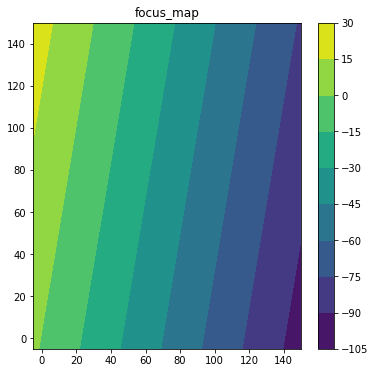

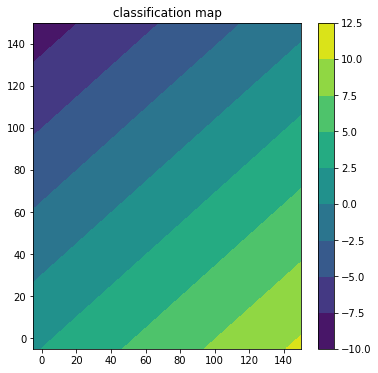

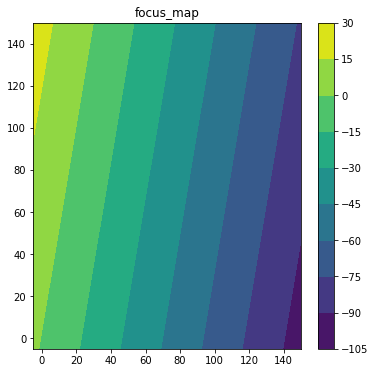

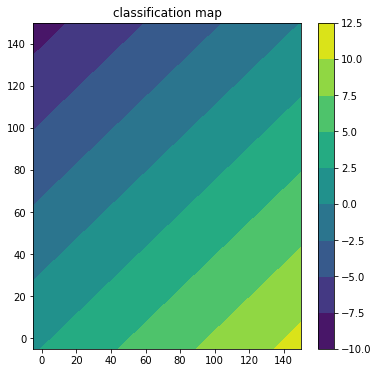

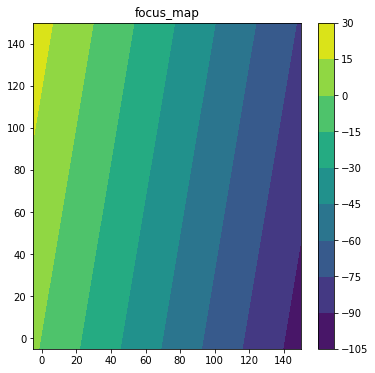

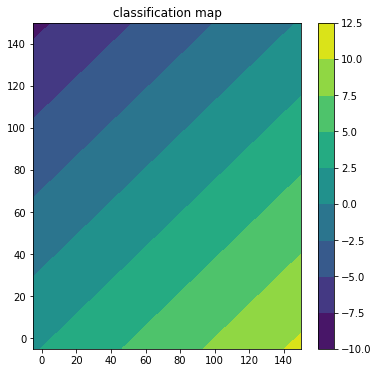

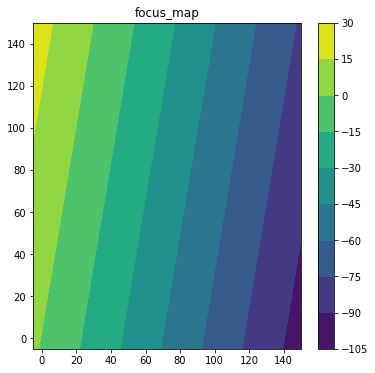

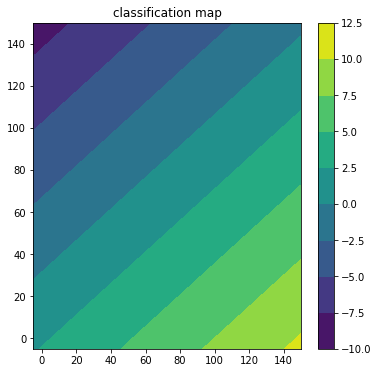

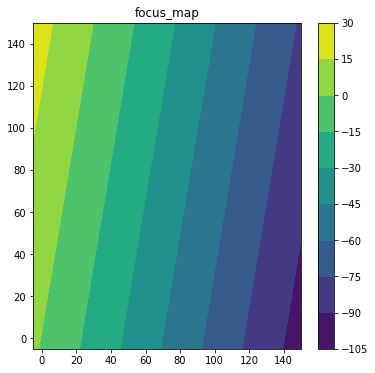

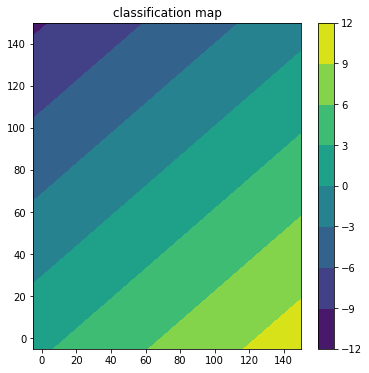

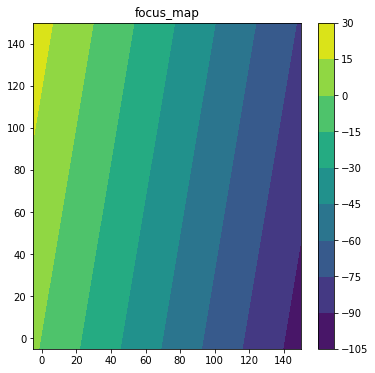

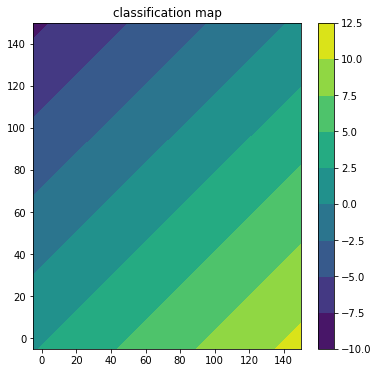

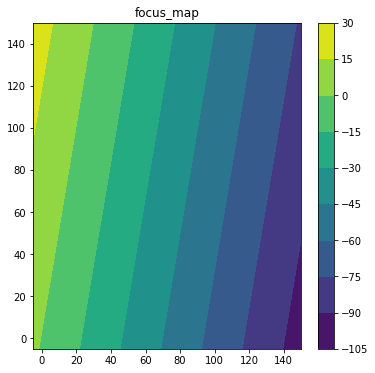

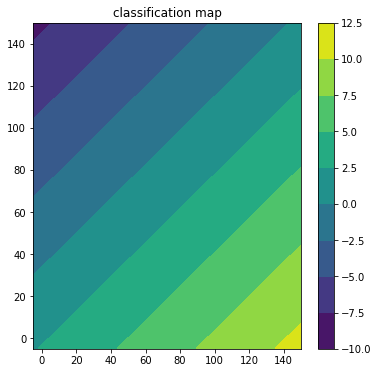

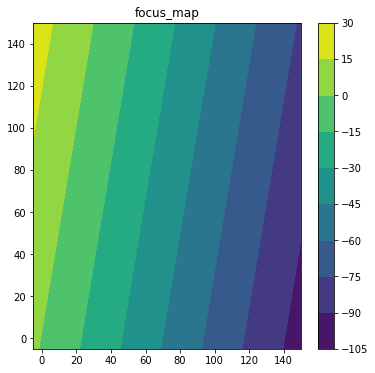

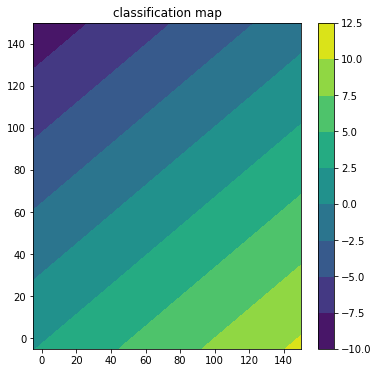

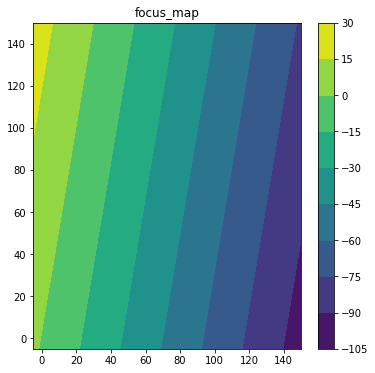

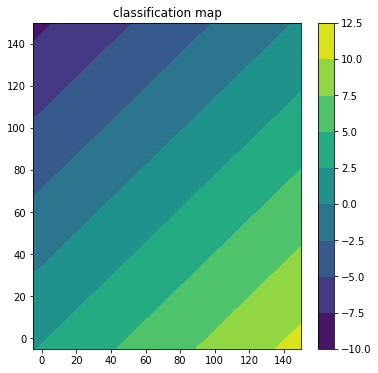

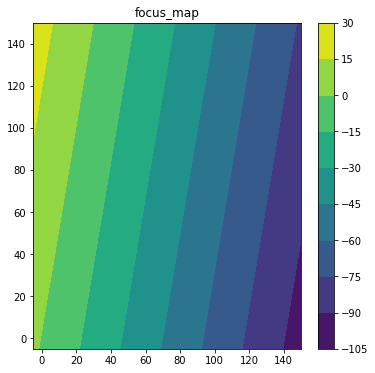

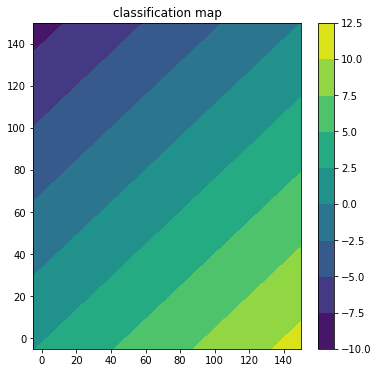

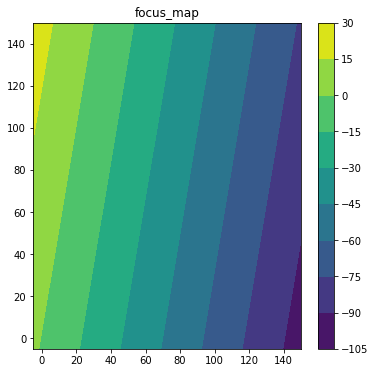

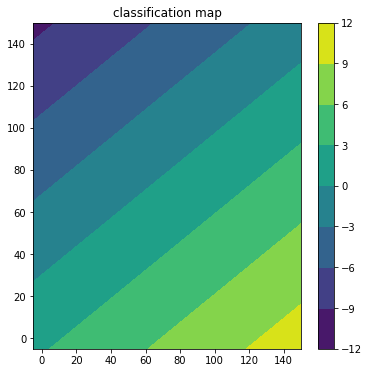

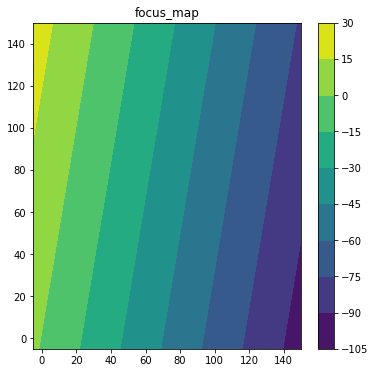

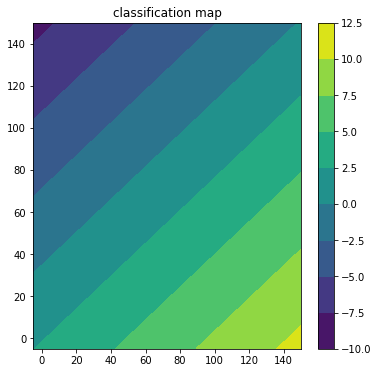

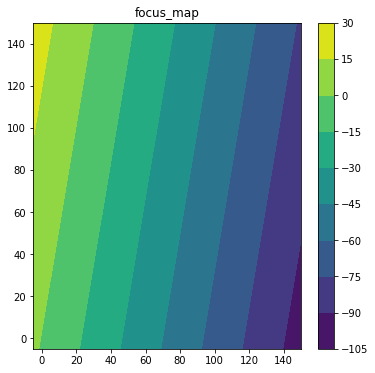

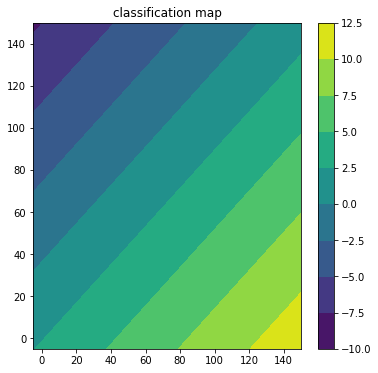

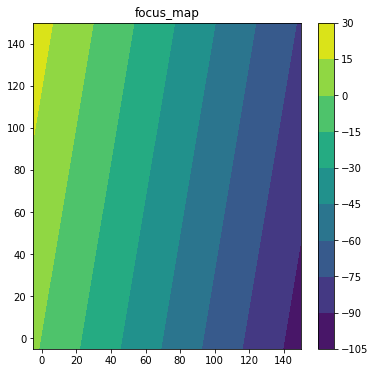

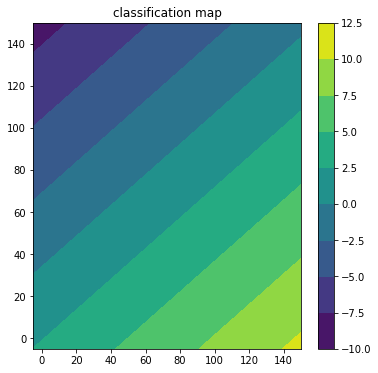

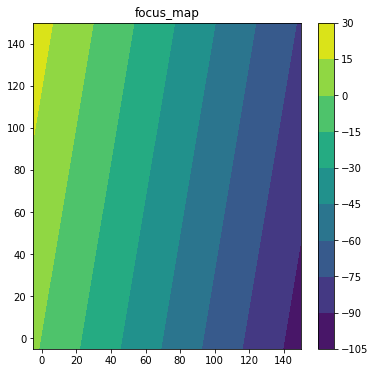

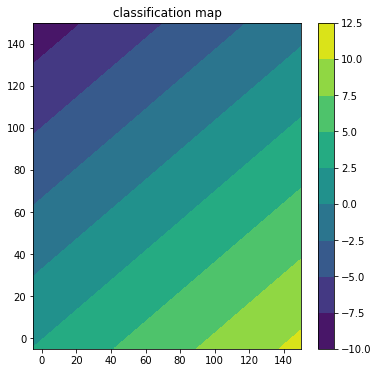

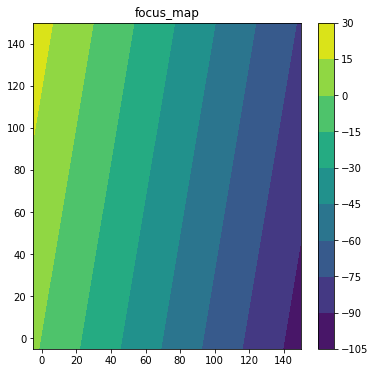

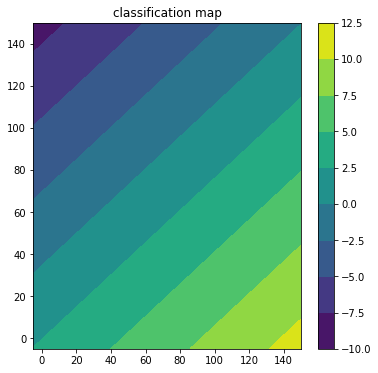

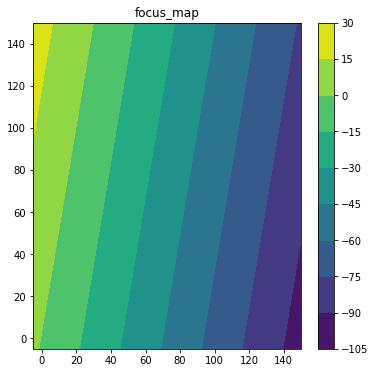

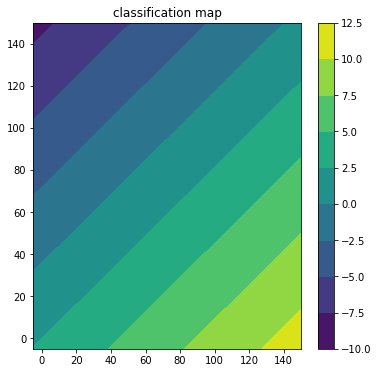

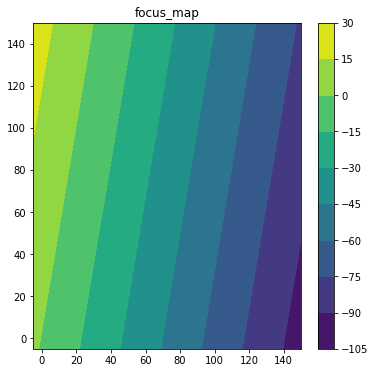

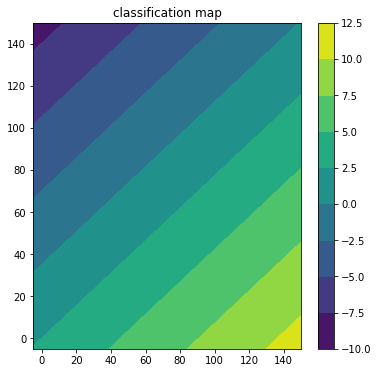

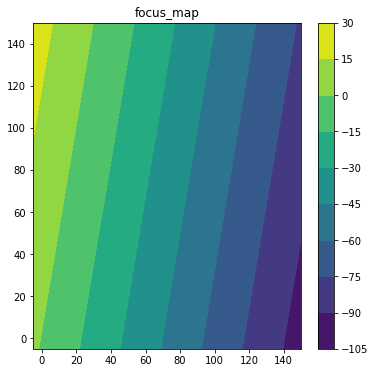

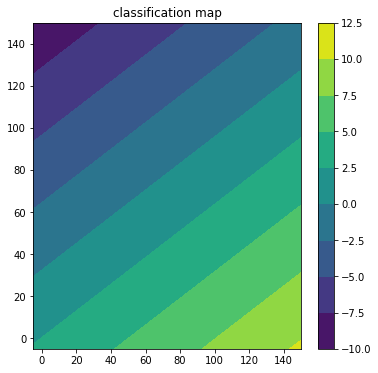

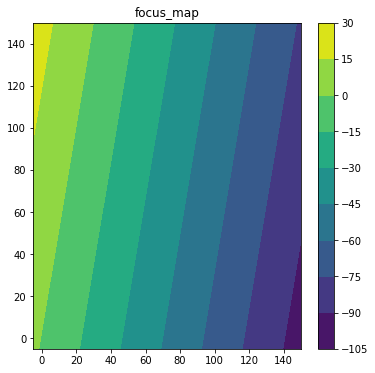

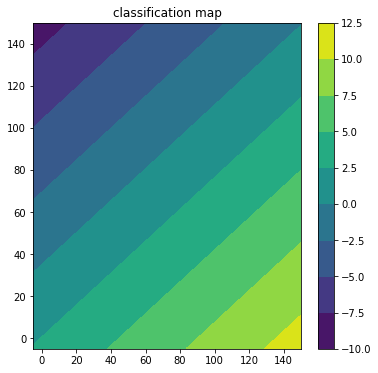

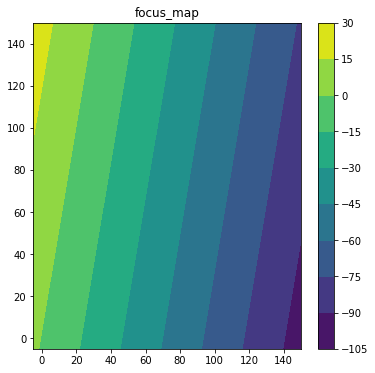

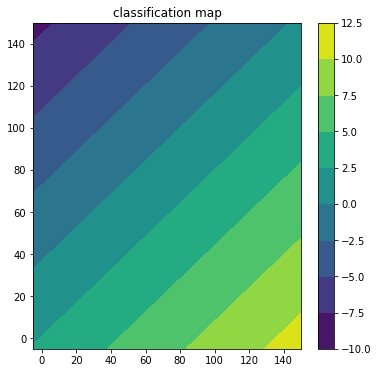

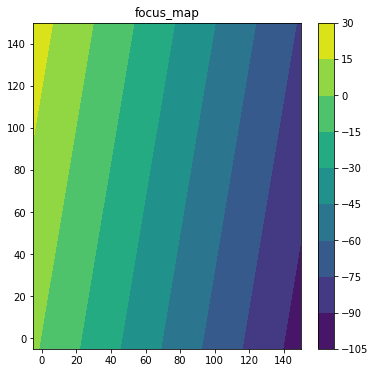

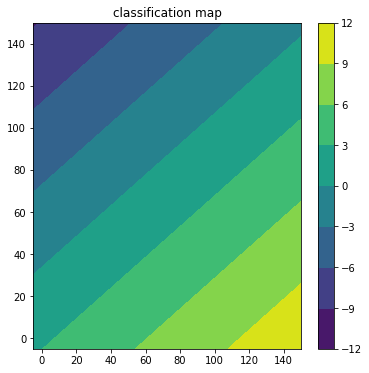

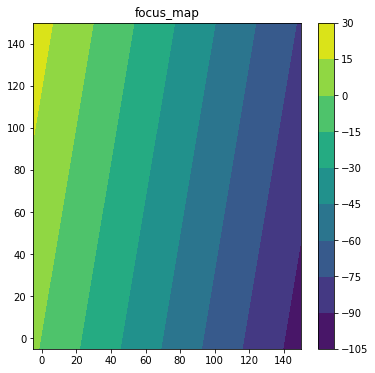

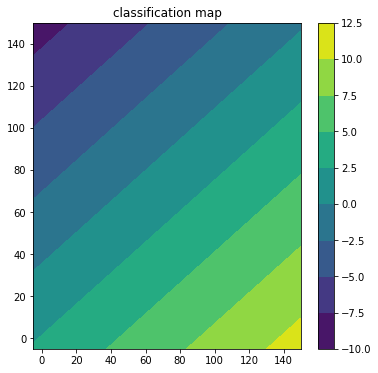

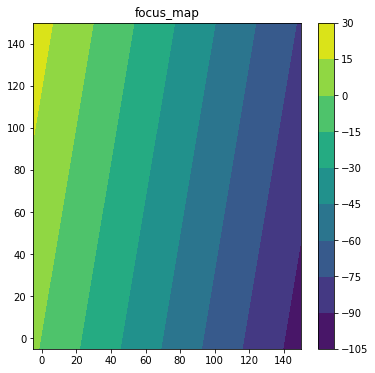

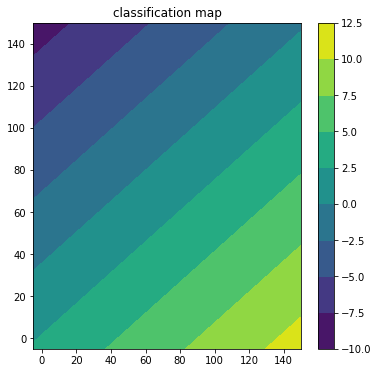

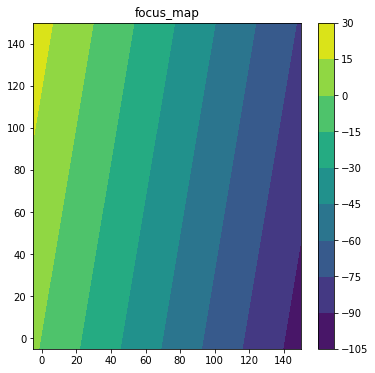

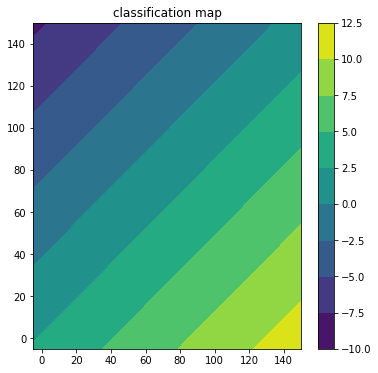

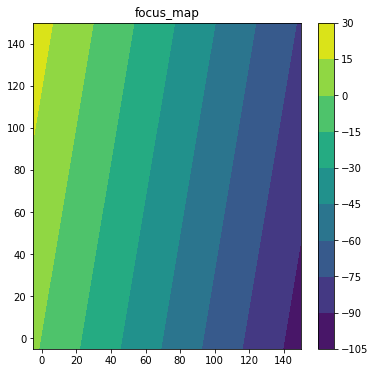

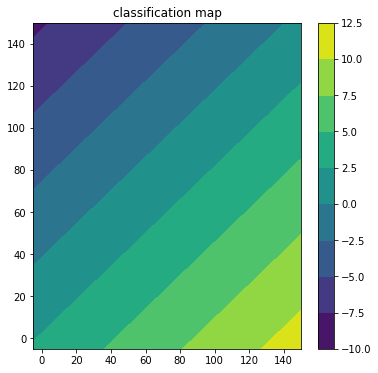

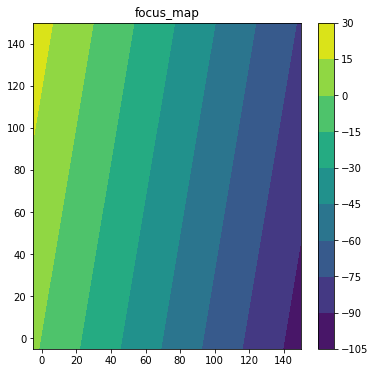

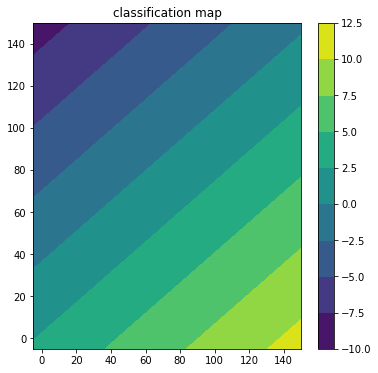

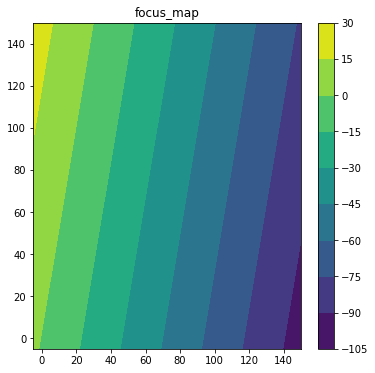

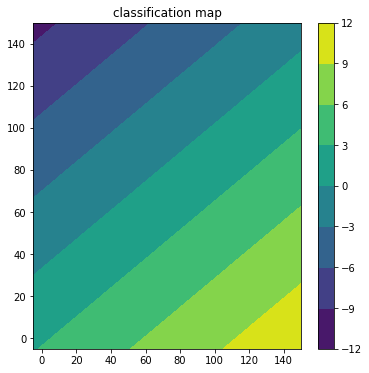

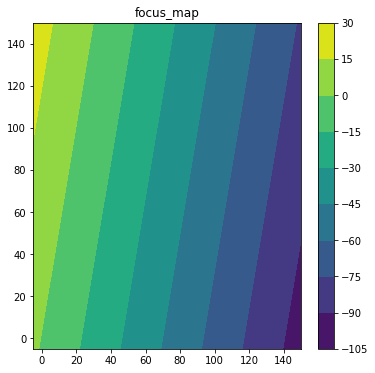

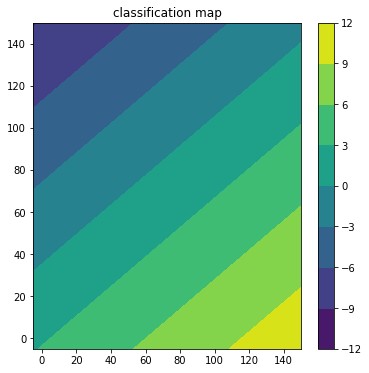

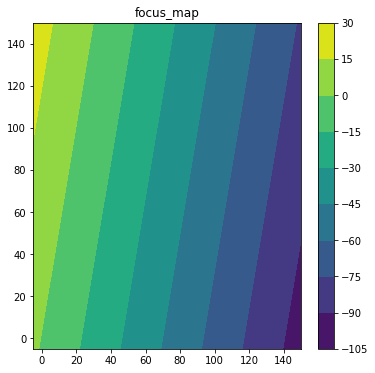

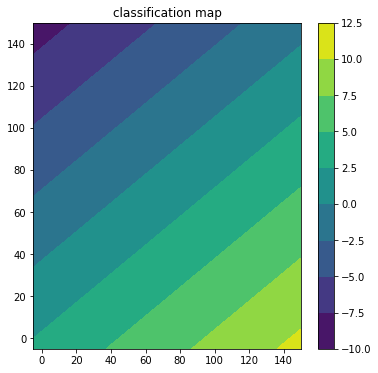

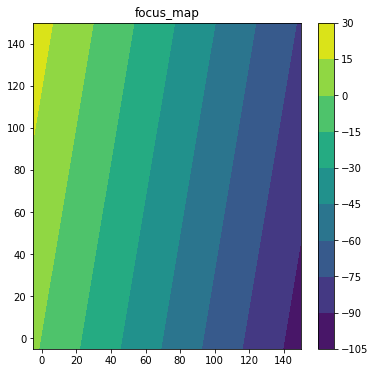

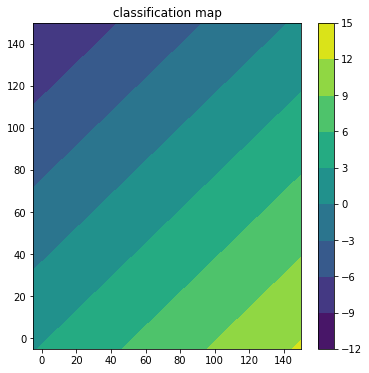

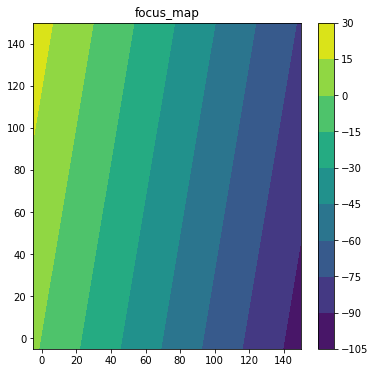

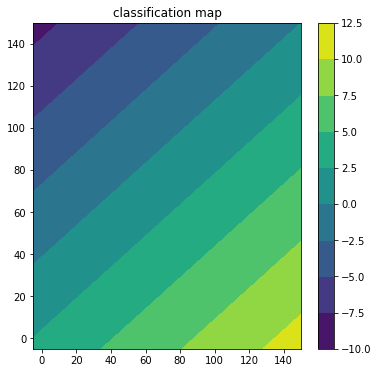

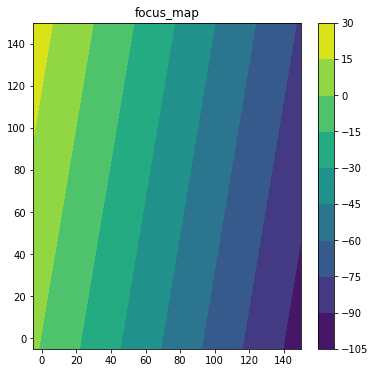

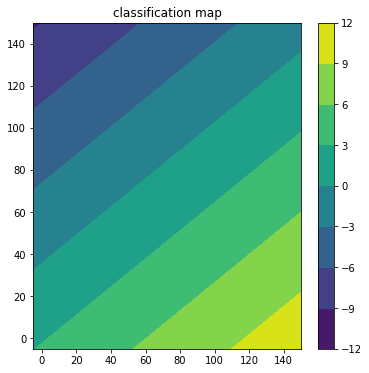

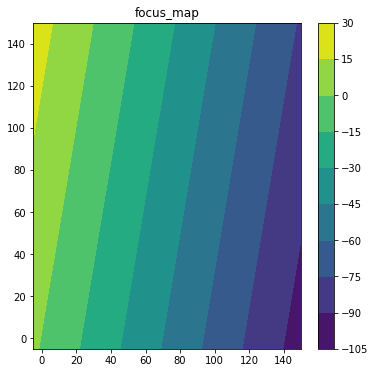

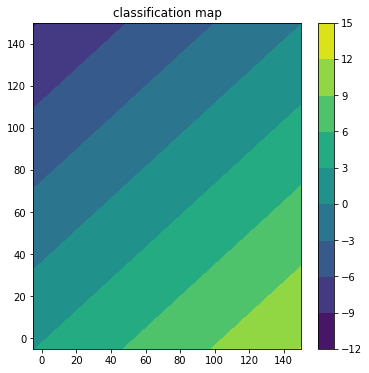

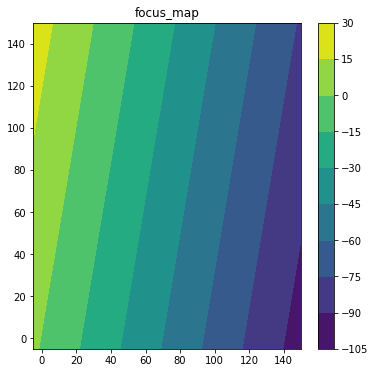

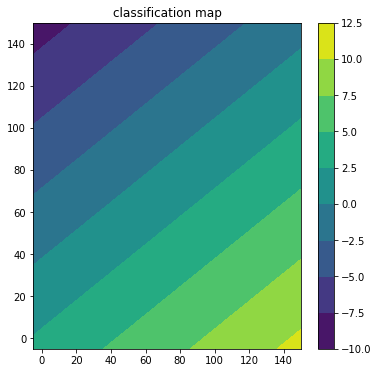

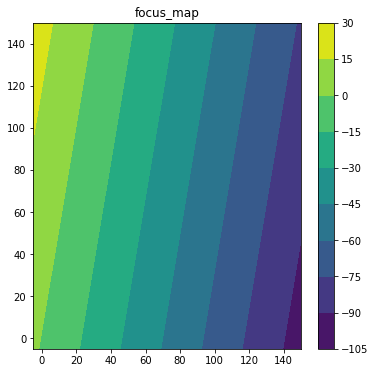

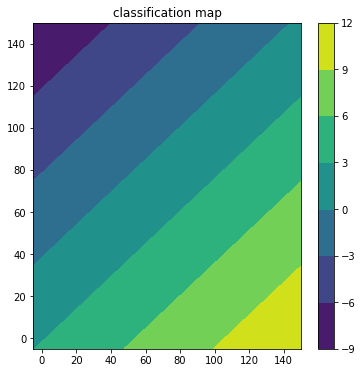

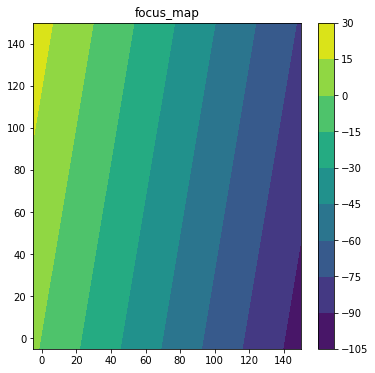

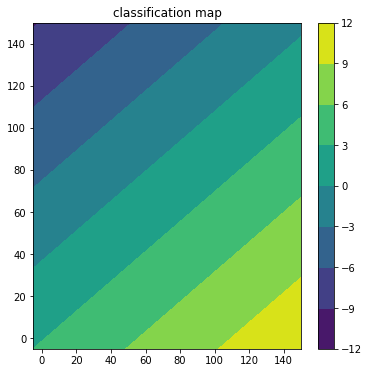

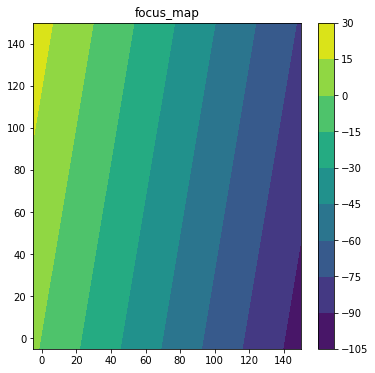

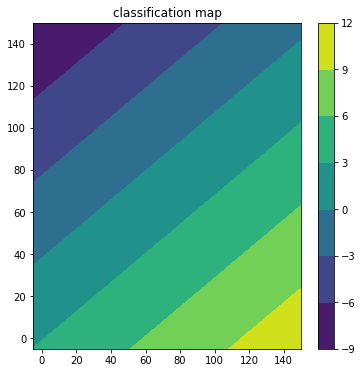

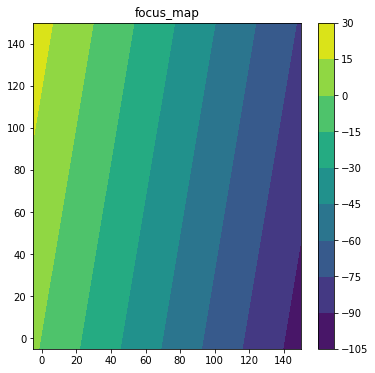

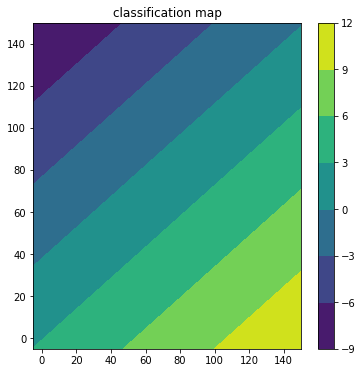

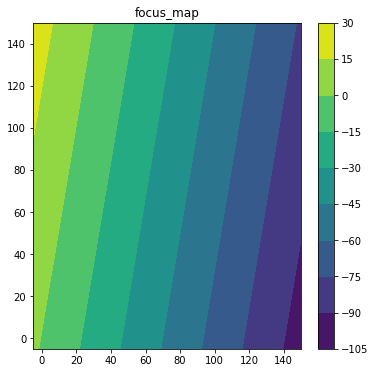

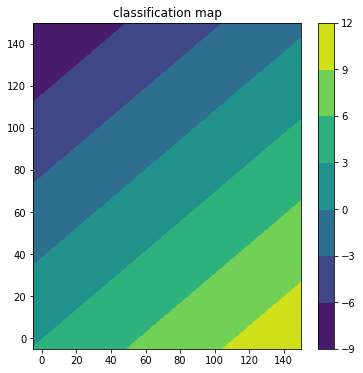

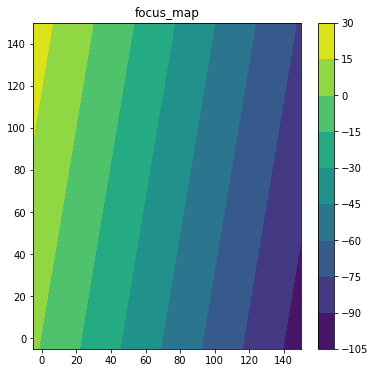

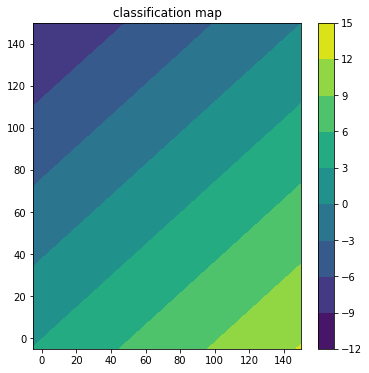

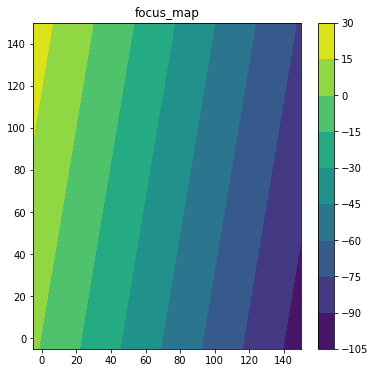

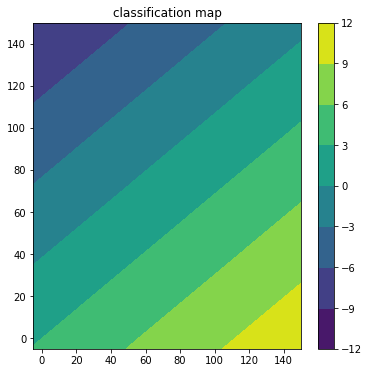

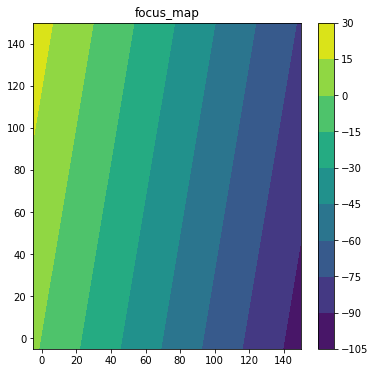

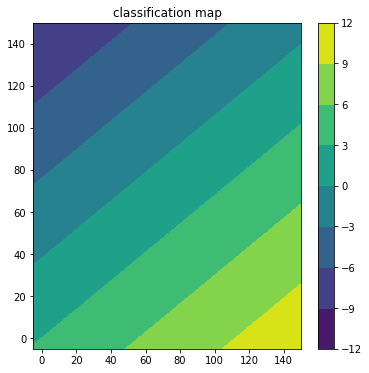

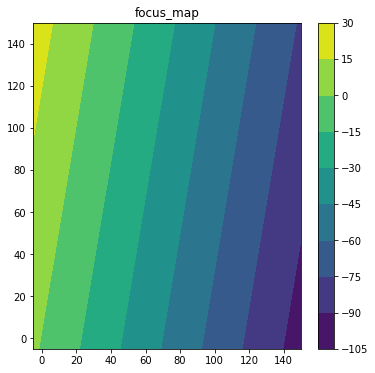

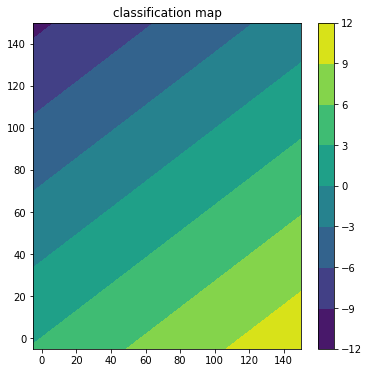

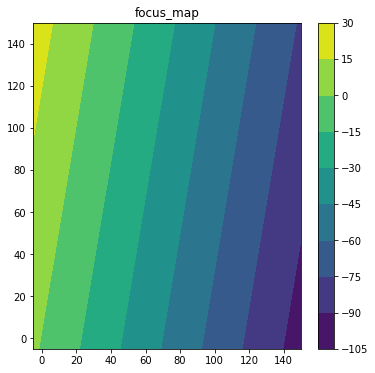

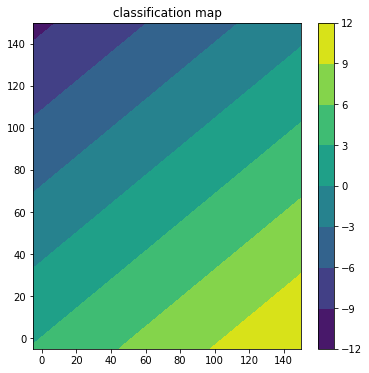

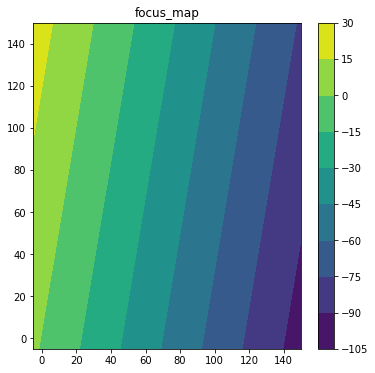

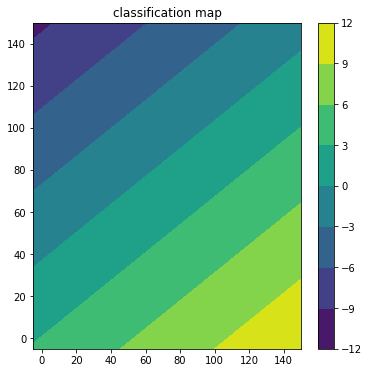

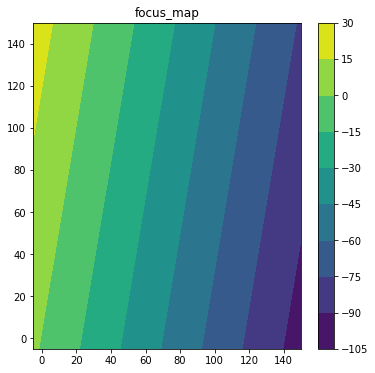

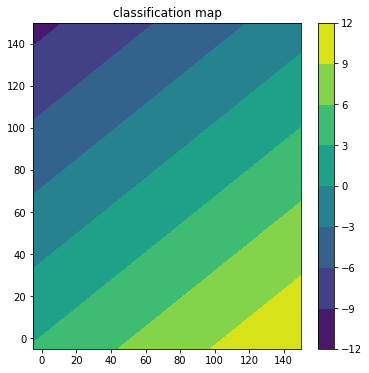

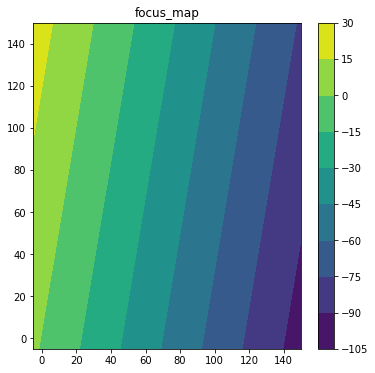

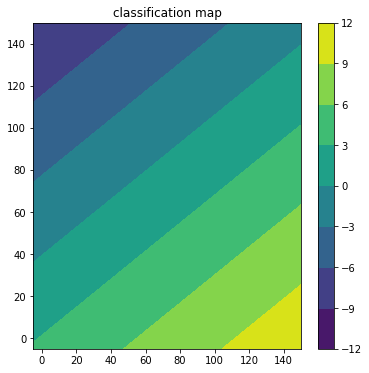

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where.parameters(), lr=0.001, momentum=0.9)
optimizer_what = optim.SGD(what.parameters(), lr=0.001, momentum=0.9)
nos_epochs = 200
train_loss=[]
train_acc = [] 
ig = np.random.randint(0,250)
col1 = []
col2 = []
col3 = []
col4 = []
col5 = []

for epoch in range(nos_epochs):  # loop over the dataset multiple times
    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0
    avg11_inp = []
    avg11_label = [] 
    running_loss = 0.0
    running_acc = 0
    cnt=0
    c = 0
    total = 0
    iteration = 384 // batch
    focus_map(where)  # visualize contour map for focus net

    classification_map(what)  # visualise contourmap for classification net
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        inputs = inputs.double()
        batch = inputs.shape[0]
        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        avg_inp,alphas = where(inputs)
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        avg11_inp.append(avg_inp.detach().numpy())
        avg11_label.append(labels.numpy())
        if(c==0):
           
            #disp_plot(inputs[11,:],avg_inp[11],labels[11].numpy()
                      #,predicted[11].numpy(), avg_inp[11,:], fore_idx[11].numpy())
            c+=1
            
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        running_acc+=sum(predicted.cpu().numpy()== labels.cpu().numpy())
        total += predicted.shape[0]
        if cnt % 7 == 6:    # print every 8 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss/7))
            print('[%d,%5d] accuracy: %.3f' %(epoch + 1, cnt+1,running_acc/total))
            
            train_loss.append(running_loss/7)
            train_acc.append(running_acc /total)
            running_loss = 0.0
            running_acc = 0
        cnt=cnt+1

        if epoch%1 == 0:
          for j in range (batch):
            focus = torch.argmax(alphas[j])
            if(focus == fore_idx[j] and predicted[j] == labels[j]):
              focus_true_pred_true += 1
            elif(focus != fore_idx[j] and predicted[j] == labels[j]):
              focus_false_pred_true +=1
            elif(focus == fore_idx[j] and predicted[j] != labels[j]):
              focus_true_pred_false +=1
            elif(focus != fore_idx[j] and predicted[j] != labels[j]):
              focus_false_pred_false +=1

    if epoch % 1 == 0:
      col1.append(epoch)
      col2.append(focus_true_pred_true)
      col3.append(focus_false_pred_true)
      col4.append(focus_true_pred_false)
      col5.append(focus_false_pred_false)
        
print('Finished Training')

        
        

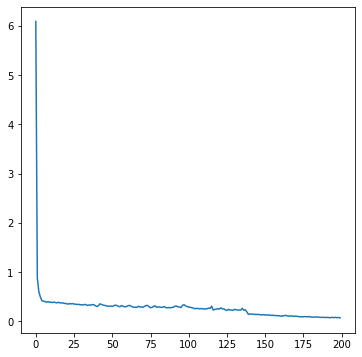

In [25]:
 plot_training_metric(train_loss,'training loss')

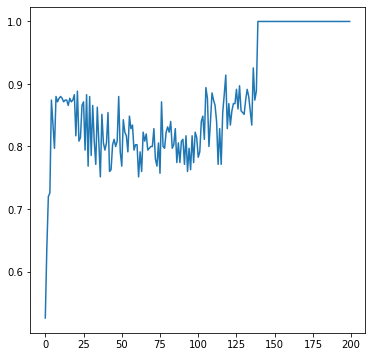

In [26]:
plot_training_metric(train_acc,'training accuracy')

In [27]:
columns = ["epochs",  "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]


In [28]:
df_train = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5

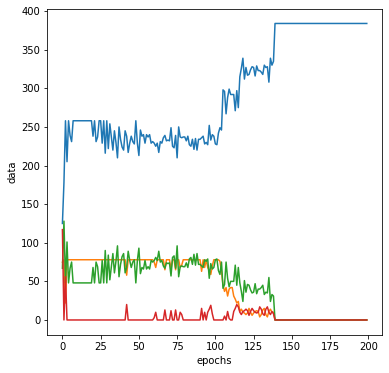

In [29]:
plot_analysis(df_train,'trends',False)


In [30]:
dat = np.concatenate(avg11_inp,axis=0)

In [31]:
lbls = np.concatenate(avg11_label,axis=0)

In [32]:
dat[:,0].shape

(384,)

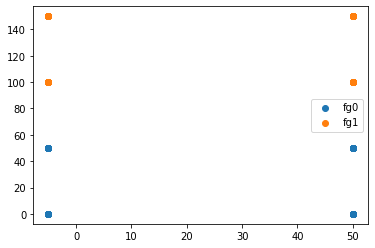

In [33]:
plt.scatter(dat[lbls==0,0],dat[lbls==0,1],label = "fg0")
plt.scatter(dat[lbls==1,0],dat[lbls==1,1],label = "fg1")
plt.legend()

In [34]:
df_train.to_csv("analysis.csv",index=False)